In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates 
scaler = MinMaxScaler(feature_range=(-1, 1))

/Users/Taras_Ustyianovych/workspace/python-envs/tg-data-research/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("data/posts_reactions_df_topic_info.parquet")
# df["ds"] = pd.to_datetime(df["ds"])
df["ds"] = pd.to_datetime(df["date"])
df = df.sort_values(by="ds")
df["ds"] = df["ds"].dt.tz_localize(None)
df["date"] = df["date"].dt.tz_localize(None)

In [3]:
df["outage"] = df.trend.apply(lambda x: 1 if x > 3 else 0)

In [4]:
pd.options.display.float_format = '{:,.10f}'.format  # set other global format

In [5]:
df = df.sort_values(by='date')

In [6]:
df = df.sort_values(by='date', ascending=True)
df['pct_change_reactions_score'] = df['reactions_score'].pct_change()

# Define reasonable caps based on your data distribution
pct_change_reactions_score_upper_cap = np.percentile(df['pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 99)
pct_change_reactions_score_lower_cap = np.percentile(df['pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 1)

# Apply caps to infinities
df['pct_change_reactions_score'] = df['pct_change_reactions_score'].replace(np.inf, pct_change_reactions_score_upper_cap)
df['pct_change_reactions_score'] = df['pct_change_reactions_score'].replace(-np.inf, pct_change_reactions_score_lower_cap)

In [7]:
df['log_pct_change_reactions_score'] = np.sign(df['pct_change_reactions_score']) * np.log1p(np.abs(df['pct_change_reactions_score']))
# df['log_pct_change_reactions_score'] = np.log(df['pct_change_reactions_score']) 

# Define reasonable caps based on your data distribution
log_pct_change_reactions_score_upper_cap = np.percentile(df['log_pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 99)
log_pct_change_reactions_score_lower_cap = np.percentile(df['log_pct_change_reactions_score'].replace([np.inf, -np.inf], np.nan).dropna(), 1)

# Apply caps to infinities
df['log_pct_change_reactions_score'] = df['log_pct_change_reactions_score'].replace(np.inf, pct_change_reactions_score_upper_cap)
df['log_pct_change_reactions_score'] = df['log_pct_change_reactions_score'].replace(-np.inf, pct_change_reactions_score_lower_cap)

In [8]:
# 1. Calculate the three moving averages
df['init_ma7'] = df['log_pct_change_reactions_score'].rolling(window=7, min_periods=1).mean()
df['ma7'] = df['init_ma7'].rolling(window=7, min_periods=1).mean()

df['init_ma15'] = df['log_pct_change_reactions_score'].rolling(window=15, min_periods=1).mean()
df['ma15'] = df['init_ma15'].rolling(window=15, min_periods=1).mean()

df['init_ma21'] = df['log_pct_change_reactions_score'].rolling(window=21, min_periods=1).mean()
df['ma21'] = df['init_ma21'].rolling(window=21, min_periods=1).mean()

In [9]:
df['reactions_score_init_ma21'] = df['reactions_score'].rolling(window=21, min_periods=1).mean()
df['reactions_score_ma21'] = df['reactions_score_init_ma21'].rolling(window=21, min_periods=1).mean()

In [10]:
df["ds"] = df["date"]

In [11]:
# # Prepare data for Prophet
# # Prophet requires a specific format with 'ds' (date) and 'y' (target variable)
# prophet_df = df.groupby('ds')[['reactions_score', 'trend']].agg({'reactions_score': 'sum', 'trend': 'mean'}).reset_index()
# prophet_df["outage"] = prophet_df.trend.apply(lambda x: 1 if x > 3 else 0)
# prophet_df = prophet_df.drop(columns = ["trend"])
# prophet_df.columns = ['ds', 'y', 'outage']
# prophet_df["ds"] = prophet_df["ds"].dt.tz_localize(None)

In [12]:
?Prophet

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    scaling: str = 'absmax',
    holidays_mode=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
    flat trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changep

In [13]:
def fit_prophet_and_get_future_forecast(data, column='y', outage_column='outage', n_changepoints=25, 
                                    changepoint_prior_scale=0.05, changepoint_range=0.95, yearly_seasonality=True, weekly_seasonality=True):
    # Prepare dataframe
    prophet_df = data[['ds', column, outage_column]].rename(columns={column: 'y'})
    
    # Fit model
    model = Prophet(n_changepoints=n_changepoints,
                    changepoint_prior_scale=changepoint_prior_scale,
                    changepoint_range=changepoint_range,
                    yearly_seasonality=yearly_seasonality,
                    weekly_seasonality=weekly_seasonality,
                   )

    # Add electricity outages as additional regressors
    model.add_regressor('outage')

    model.fit(prophet_df)
    
    # Get forecast and extract changepoint information
    future = model.make_future_dataframe(periods=0)  # No forecasting needed
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=0)  # No forecast, just analyze historical data
    if 'outage' in prophet_df.columns:
        future = future.merge(prophet_df[['ds', 'outage']], on='ds', how='left')

    forecast = model.predict(future)
    
    return model, forecast, prophet_df

In [14]:
log_pct_change_reactions_score_model, log_pct_change_reactions_score_forecast, log_pct_change_reactions_score_df = fit_prophet_and_get_future_forecast(
    df[["ds", "log_pct_change_reactions_score", "outage"]], column='log_pct_change_reactions_score'
)

15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:29 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
ma7_model, ma7_forecast, ma7_df = fit_prophet_and_get_future_forecast(
    df[["ds", "ma7", "outage"]], column='ma7'
)

15:17:30 - cmdstanpy - INFO - Chain [1] start processing
15:17:30 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
ma15_model, ma15_forecast, ma15_df = fit_prophet_and_get_future_forecast(
    df[["ds", "ma15", "outage"]], column='ma15'
)

15:17:31 - cmdstanpy - INFO - Chain [1] start processing
15:17:31 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
ma21_model, ma21_forecast, ma21_df = fit_prophet_and_get_future_forecast(
    df[["ds", "ma21", "outage"]], column='ma21'
)

15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:32 - cmdstanpy - INFO - Chain [1] done processing


#### MA21 Forecast

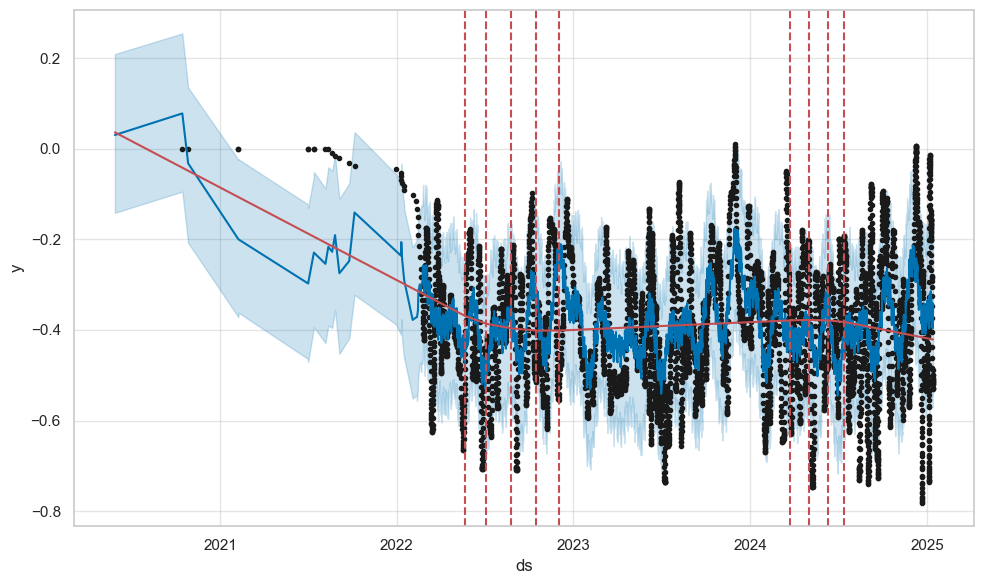

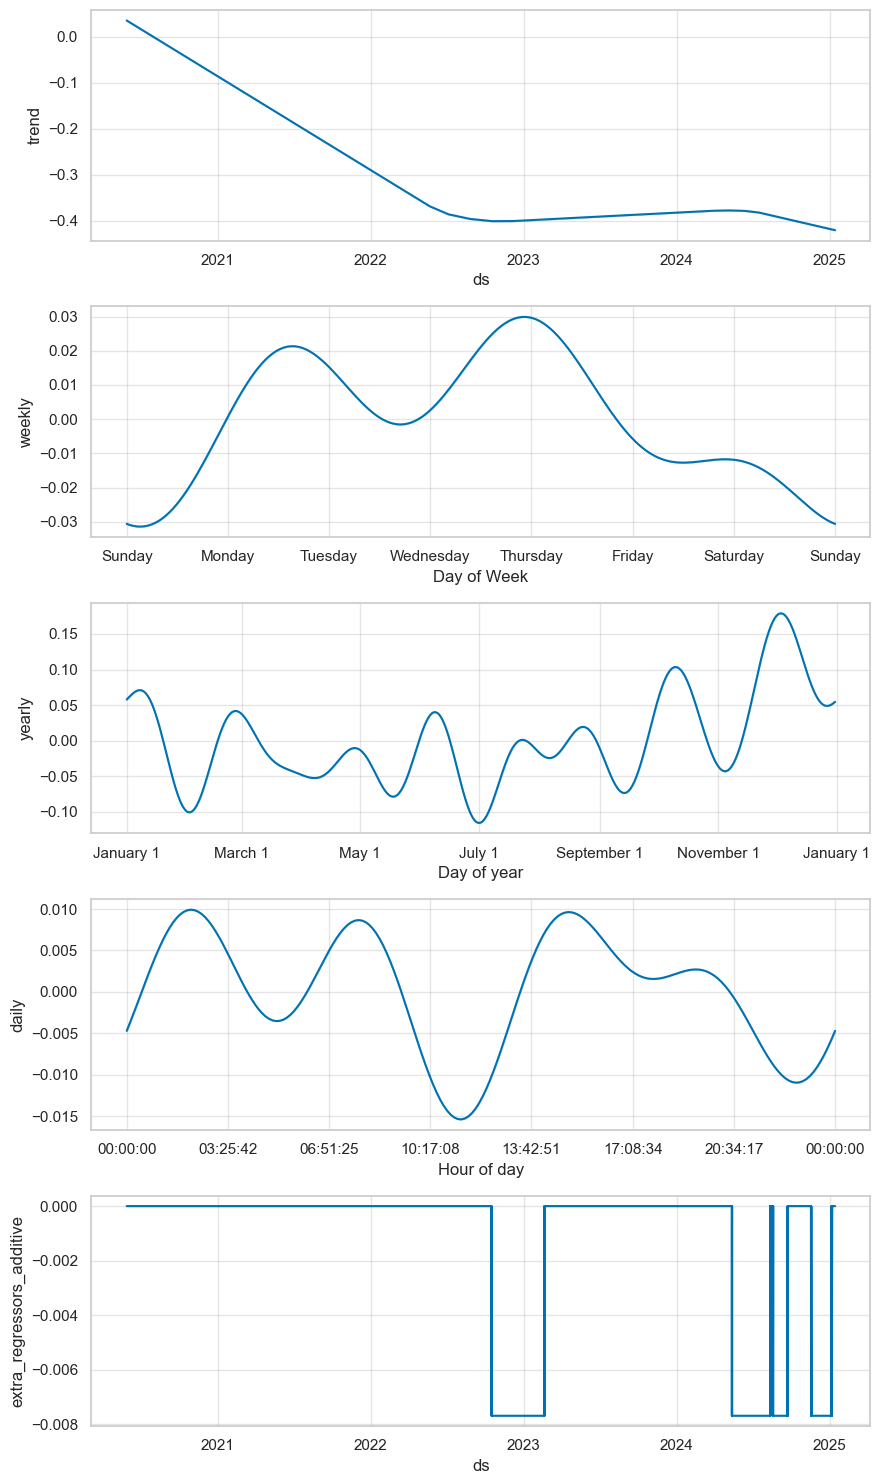

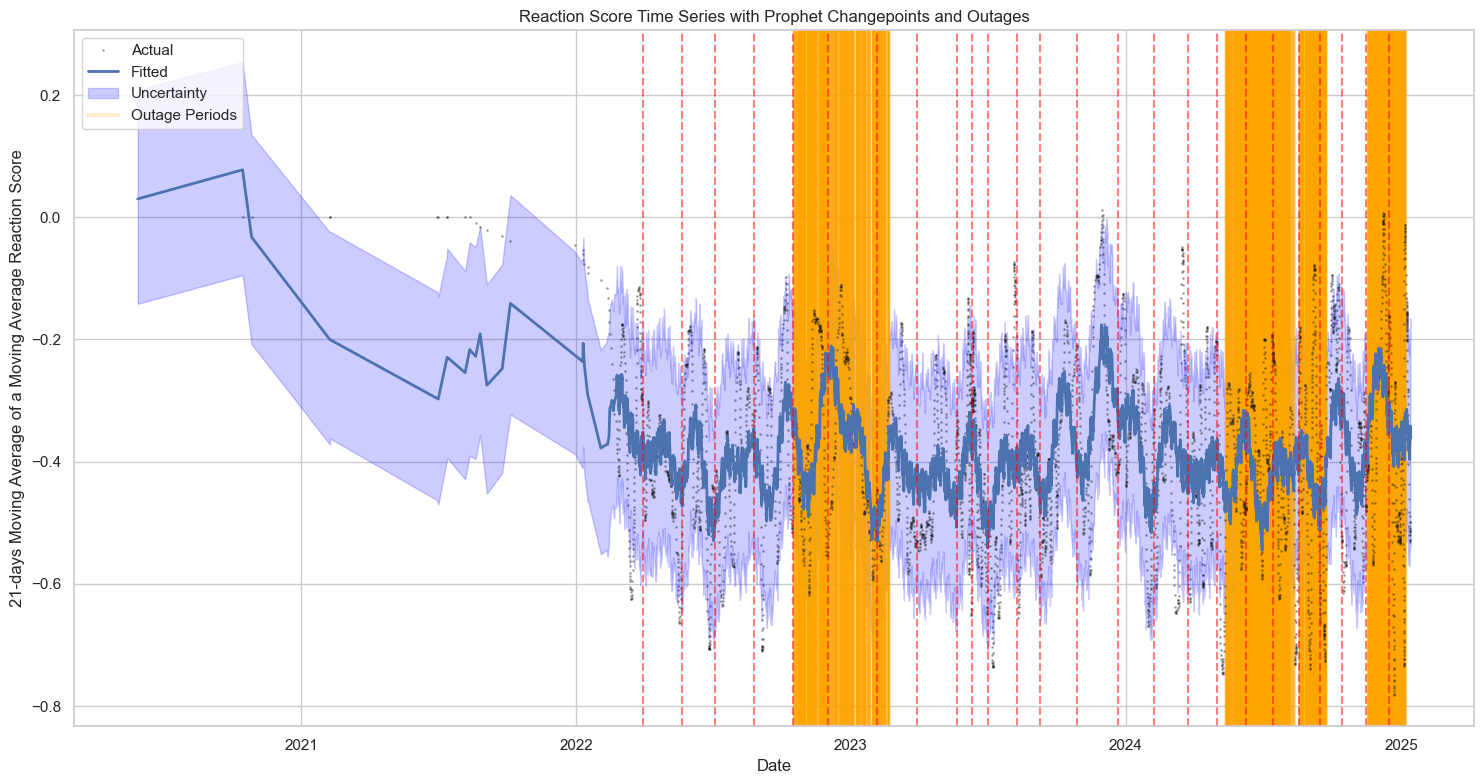

In [32]:
# Plot results with automatically detected changepoints
fig = ma21_model.plot(ma21_forecast)
a = add_changepoints_to_plot(fig.gca(), ma21_model, ma21_forecast)

# Plot component breakdown
fig2 = ma21_model.plot_components(ma21_forecast)

# Create a more detailed plot showing outages and detected changepoints
plt.figure(figsize=(15, 8))
plt.plot(ma21_df['ds'], ma21_df['y'], 'ko', markersize=1, alpha=0.3, label='Actual')
plt.plot(ma21_forecast['ds'], ma21_forecast['yhat'], 'b-', linewidth=2, label='Fitted')
plt.fill_between(ma21_forecast['ds'], ma21_forecast['yhat_lower'], ma21_forecast['yhat_upper'], 
                color='blue', alpha=0.2, label='Uncertainty')

# Highlight detected changepoints
for cp in ma21_model.changepoints:
    plt.axvline(x=cp, color='red', linestyle='--', alpha=0.5)

# Highlight outage periods if available
if 'outage' in ma21_df.columns:
    outage_periods = ma21_df[ma21_df['outage'] == 1]['ds']
    for date in outage_periods:
        plt.axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='orange')
    
    # Add outage period label
    plt.plot([], [], color='orange', alpha=0.2, linewidth=3, label='Outage Periods')

plt.title('Reaction Score Time Series with Prophet Changepoints and Outages')
plt.legend()
plt.xlabel('Date')
plt.ylabel('21-days Moving Average of a Moving Average Reaction Score')
plt.tight_layout()
plt.show()

#### Visualize all four log-transformed percentage change forecasts with uncertainty bounds

<Figure size 1920x1440 with 0 Axes>

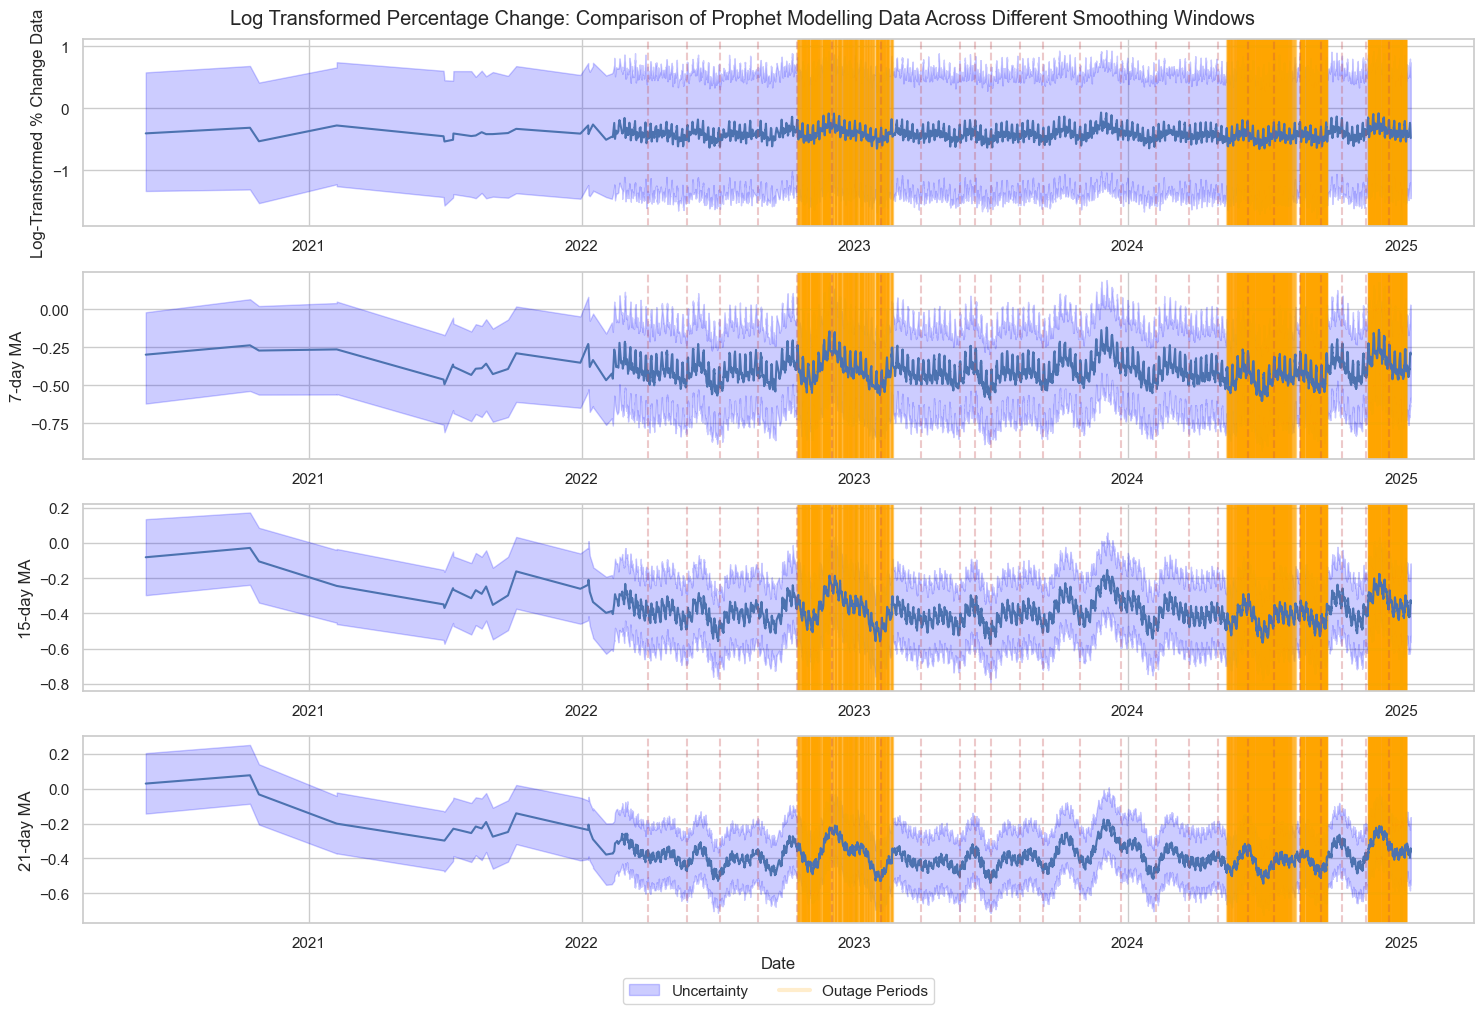

In [45]:
plt.figure(dpi=300)
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))


# Create subplots for each time series
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2)
ax3 = plt.subplot(4, 1, 3)
ax4 = plt.subplot(4, 1, 4, sharex=ax1)  # Share x-axis with first plot

# Plot each time series with vertical lines for changepoints
for ax, label, forecast_data, model, data_df in [
    (ax1, 'Log-Transformed % Change Data', log_pct_change_reactions_score_forecast, log_pct_change_reactions_score_model, log_pct_change_reactions_score_df),
    (ax2, '7-day MA', ma7_forecast, ma7_model, ma7_df),
    (ax3, '15-day MA', ma15_forecast, ma15_model, ma15_df),
    (ax4, '21-day MA', ma21_forecast, ma21_model, ma21_df)
]:
    # Plot the time series
    ax.plot(forecast_data['ds'], forecast_data['yhat'], color='b')
    ax.set_ylabel(label)
    ax.fill_between(forecast_data['ds'], forecast_data['yhat_lower'], forecast_data['yhat_upper'], 
                color='blue', alpha=0.2, label='Uncertainty')

    cp_data = pd.DataFrame(model.changepoints)
    
    # Add vertical lines for top 5 changepoints
    for i, row in cp_data.iterrows():
        ax.axvline(x=row['ds'], color='r', linestyle='--', alpha=0.3)
        # ax.text(row['date'], ax.get_ylim()[1], f"{row['date'].date()}", 
                # rotation=90, verticalalignment='top', fontsize=9)

    # Highlight outage periods if available
    if 'outage' in data_df.columns:
        outage_periods = data_df[data_df['outage'] == 1]['ds']
        for date in outage_periods:
            ax.axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='orange')
        
        # Add outage period label
        ax.plot([], [], color='orange', alpha=0.2, linewidth=3, label='Outage Periods')

ax4.set_xlabel('Date')
plt.suptitle('Log Transformed Percentage Change: Comparison of Prophet Modelling Data Across Different Smoothing Windows')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=False, ncol=5)
plt.show()

<Figure size 1920x1440 with 0 Axes>

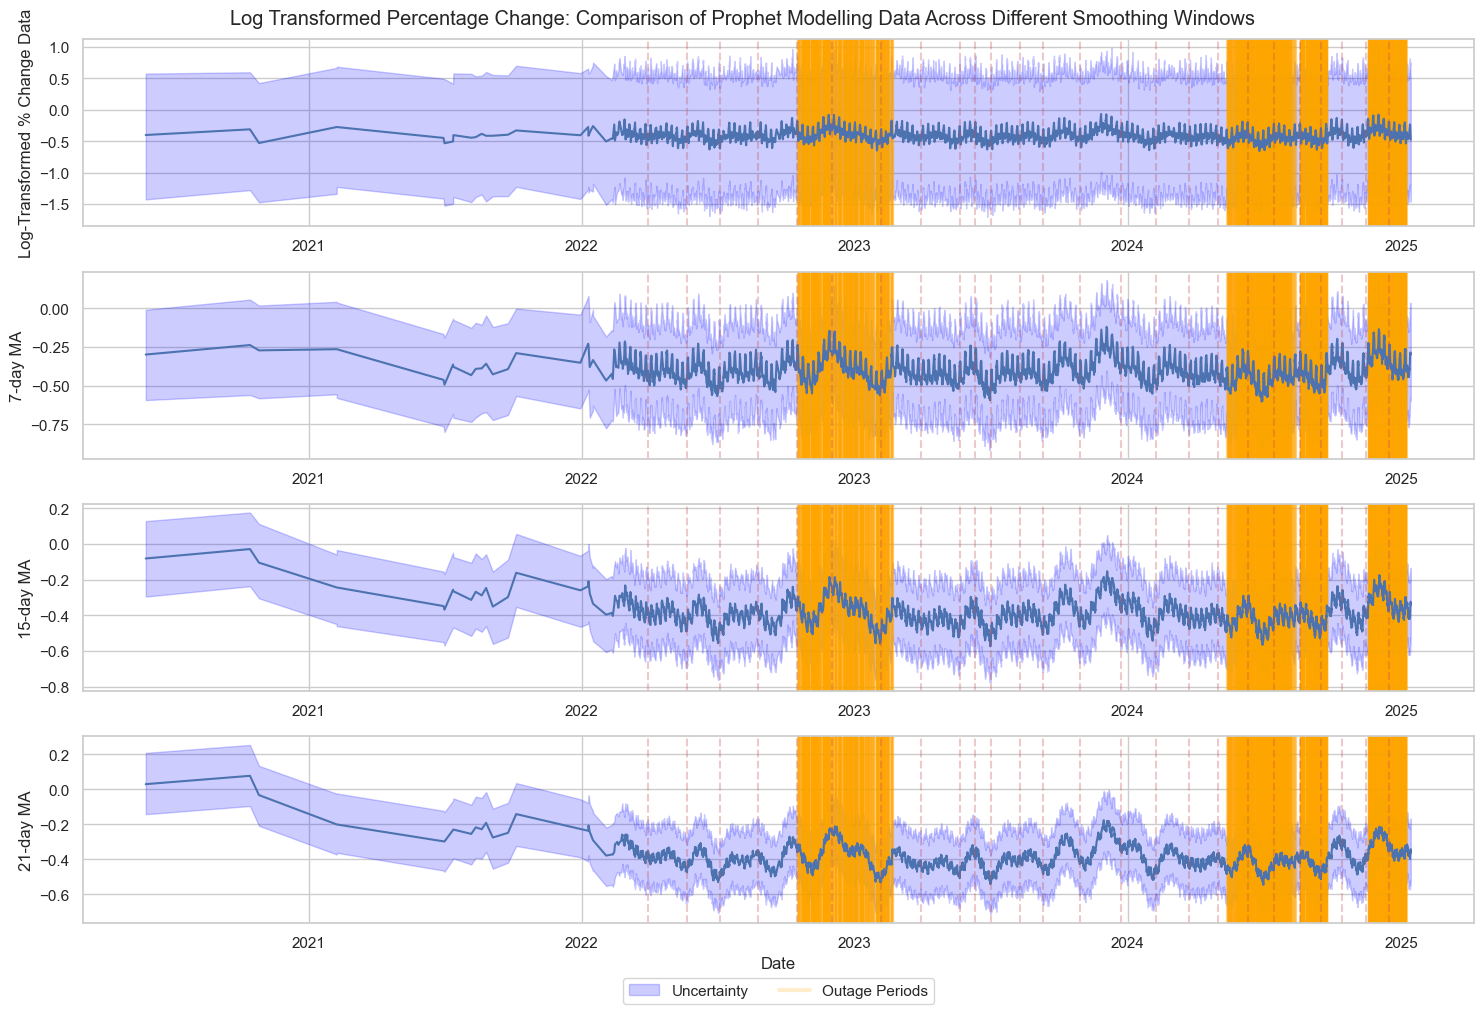

In [33]:
plt.figure(dpi=300)
sns.set(style="whitegrid")

plt.figure(figsize=(15, 10))


# Create subplots for each time series
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2)
ax3 = plt.subplot(4, 1, 3)
ax4 = plt.subplot(4, 1, 4, sharex=ax1)  # Share x-axis with first plot

# Plot each time series with vertical lines for changepoints
for ax, label, forecast_data, model, data_df in [
    (ax1, 'Log-Transformed % Change Data', log_pct_change_reactions_score_forecast, log_pct_change_reactions_score_model, log_pct_change_reactions_score_df),
    (ax2, '7-day MA', ma7_forecast, ma7_model, ma7_df),
    (ax3, '15-day MA', ma15_forecast, ma15_model, ma15_df),
    (ax4, '21-day MA', ma21_forecast, ma21_model, ma21_df)
]:
    # Plot the time series
    ax.plot(forecast_data['ds'], forecast_data['yhat'], color='b')
    ax.set_ylabel(label)
    ax.fill_between(forecast_data['ds'], forecast_data['yhat_lower'], forecast_data['yhat_upper'], 
                color='blue', alpha=0.2, label='Uncertainty')

    cp_data = pd.DataFrame(model.changepoints)
    
    # Add vertical lines for top 5 changepoints
    for i, row in cp_data.iterrows():
        ax.axvline(x=row['ds'], color='r', linestyle='--', alpha=0.3)
        # ax.text(row['date'], ax.get_ylim()[1], f"{row['date'].date()}", 
                # rotation=90, verticalalignment='top', fontsize=9)

    # Highlight outage periods if available
    if 'outage' in data_df.columns:
        outage_periods = data_df[data_df['outage'] == 1]['ds']
        for date in outage_periods:
            ax.axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='orange')
        
        # Add outage period label
        ax.plot([], [], color='orange', alpha=0.2, linewidth=3, label='Outage Periods')

ax4.set_xlabel('Date')
plt.suptitle('Log Transformed Percentage Change: Comparison of Prophet Modelling Data Across Different Smoothing Windows')
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=False, ncol=5)
plt.show()

In [27]:
# Option 1
# A more direct way to get changepoint effects
changepoint_effects = ma21_model.params['delta'].flatten()
changepoints_df = pd.DataFrame({
    'changepoint': ma21_model.changepoints,
    'changepoint_value': changepoint_effects
})

# Print the most significant changepoints (absolute magnitude)
significant_changepoints = changepoints_df.sort_values(by='changepoint_value', key=abs, ascending=False)
print("Top 10 Most Significant Changepoints:")
print(significant_changepoints.head(10))

Top 10 Most Significant Changepoints:
             changepoint  changepoint_value
612  2022-07-04 10:51:31       0.3985820000
408  2022-05-21 21:10:11       0.3139680000
4077 2024-07-14 07:34:58      -0.2165340000
815  2022-08-25 06:17:38       0.2002760000
1019 2022-10-16 04:46:36       0.1915480000
3873 2024-06-09 15:10:28      -0.1625020000
1223 2022-12-01 16:53:28       0.0908752000
3669 2024-05-01 11:23:06      -0.0842749000
3465 2024-03-23 11:48:15      -0.0516099000
204  2022-03-30 15:27:21       0.0091349200


In [111]:
changepoints_df.sort_values(by='changepoint')

changepoint  changepoint_value  near_outage
204  2022-03-30 15:27:21       0.0091349200        False
408  2022-05-21 21:10:11       0.3139680000        False
612  2022-07-04 10:51:31       0.3985820000        False
815  2022-08-25 06:17:38       0.2002760000        False
1019 2022-10-16 04:46:36       0.1915480000         True
1223 2022-12-01 16:53:28       0.0908752000         True
1427 2023-02-04 20:11:00       0.0007887600         True
1631 2023-03-30 02:43:01       0.0017385200        False
1835 2023-05-21 11:31:46      -0.0000000259        False
2038 2023-06-11 08:06:25       0.0000046408        False
2242 2023-07-02 17:21:41       0.0000720964        False
2446 2023-08-09 15:19:24       0.0000010257        False
2650 2023-09-09 17:03:16       0.0000015262        False
2854 2023-10-29 02:31:27      -0.0000000432        False
3058 2023-12-22 15:16:30       0.0000000699        False
3261 2024-02-08 10:21:08      -0.0000004133        False
3465 2024-03-23 11:48:15      -0.0516099000        False
3669 2024-05-01 11:23:06      -0.0842749000        False
3873 2024-06-09 15:10:28      -0.1625020000         True
4077 2024-07-14 07:34:58      -0.2165340000         True
4281 2024-08-18 17:13:12      -0.0000002410         True
4484 2024-09-15 15:58:11       0.0000000376         True
4688 2024-10-14 04:25:12      -0.0000007087        False
4892 2024-11-14 21:14:24      -0.0000000113         True
5096 2024-12-15 18:38:22       0.0000000673         True

In [19]:
changepoints_per_model_df = pd.DataFrame({
    'ma21_changepoint': ma21_model.changepoints.sort_values(),
    'ma15_changepoints': ma15_model.changepoints.sort_values(),
    'ma7_changepoints': ma7_model.changepoints.sort_values(),
    'log_pct_change_changepoints': log_pct_change_reactions_score_model.changepoints.sort_values(),
})


In [20]:
changepoints_per_model_df

ma21_changepoint   ma15_changepoints    ma7_changepoints  \
204  2022-03-30 15:27:21 2022-03-30 15:27:21 2022-03-30 15:27:21   
408  2022-05-21 21:10:11 2022-05-21 21:10:11 2022-05-21 21:10:11   
612  2022-07-04 10:51:31 2022-07-04 10:51:31 2022-07-04 10:51:31   
815  2022-08-25 06:17:38 2022-08-25 06:17:38 2022-08-25 06:17:38   
1019 2022-10-16 04:46:36 2022-10-16 04:46:36 2022-10-16 04:46:36   
1223 2022-12-01 16:53:28 2022-12-01 16:53:28 2022-12-01 16:53:28   
1427 2023-02-04 20:11:00 2023-02-04 20:11:00 2023-02-04 20:11:00   
1631 2023-03-30 02:43:01 2023-03-30 02:43:01 2023-03-30 02:43:01   
1835 2023-05-21 11:31:46 2023-05-21 11:31:46 2023-05-21 11:31:46   
2038 2023-06-11 08:06:25 2023-06-11 08:06:25 2023-06-11 08:06:25   
2242 2023-07-02 17:21:41 2023-07-02 17:21:41 2023-07-02 17:21:41   
2446 2023-08-09 15:19:24 2023-08-09 15:19:24 2023-08-09 15:19:24   
2650 2023-09-09 17:03:16 2023-09-09 17:03:16 2023-09-09 17:03:16   
2854 2023-10-29 02:31:27 2023-10-29 02:31:27 2023-10-29 02:31:27   
3058 2023-12-22 15:16:30 2023-12-22 15:16:30 2023-12-22 15:16:30   
3261 2024-02-08 10:21:08 2024-02-08 10:21:08 2024-02-08 10:21:08   
3465 2024-03-23 11:48:15 2024-03-23 11:48:15 2024-03-23 11:48:15   
3669 2024-05-01 11:23:06 2024-05-01 11:23:06 2024-05-01 11:23:06   
3873 2024-06-09 15:10:28 2024-06-09 15:10:28 2024-06-09 15:10:28   
4077 2024-07-14 07:34:58 2024-07-14 07:34:58 2024-07-14 07:34:58   
4281 2024-08-18 17:13:12 2024-08-18 17:13:12 2024-08-18 17:13:12   
4484 2024-09-15 15:58:11 2024-09-15 15:58:11 2024-09-15 15:58:11   
4688 2024-10-14 04:25:12 2024-10-14 04:25:12 2024-10-14 04:25:12   
4892 2024-11-14 21:14:24 2024-11-14 21:14:24 2024-11-14 21:14:24   
5096 2024-12-15 18:38:22 2024-12-15 18:38:22 2024-12-15 18:38:22   

     log_pct_change_changepoints  
204          2022-03-30 15:27:21  
408          2022-05-21 21:10:11  
612          2022-07-04 10:51:31  
815          2022-08-25 06:17:38  
1019         2022-10-16 04:46:36  
1223         2022-12-01 16:53:28  
1427         2023-02-04 20:11:00  
1631         2023-03-30 02:43:01  
1835         2023-05-21 11:31:46  
2038         2023-06-11 08:06:25  
2242         2023-07-02 17:21:41  
2446         2023-08-09 15:19:24  
2650         2023-09-09 17:03:16  
2854         2023-10-29 02:31:27  
3058         2023-12-22 15:16:30  
3261         2024-02-08 10:21:08  
3465         2024-03-23 11:48:15  
3669         2024-05-01 11:23:06  
3873         2024-06-09 15:10:28  
4077         2024-07-14 07:34:58  
4281         2024-08-18 17:13:12  
4484         2024-09-15 15:58:11  
4688         2024-10-14 04:25:12  
4892         2024-11-14 21:14:24  
5096         2024-12-15 18:38:22

In [53]:
differences = []
for column_i in changepoints_per_model_df.columns:
    for column_j in changepoints_per_model_df.columns:
        if column_i == column_j:
            continue
        else:
            difference = changepoints_per_model_df[column_i] - changepoints_per_model_df[column_j]
            difference_days = difference.apply(lambda x: x.seconds).to_list()
            differences.extend(difference_days)

In [55]:
np.mean(differences)

0.0

In [28]:
# Check if changepoints coincide with outage events
if 'outage' in ma21_df.columns:
    # Define a window (e.g., 3 days) to check for outages near changepoints
    window = pd.Timedelta(days=3)
    
    def outage_near_changepoint(cp):
        return any((ma21_df['outage'] == 1) & 
                  (ma21_df['ds'] >= cp - window) & 
                  (ma21_df['ds'] <= cp + window))
    
    changepoints_df['near_outage'] = changepoints_df['changepoint'].apply(outage_near_changepoint)
    
    # Count how many changepoints coincide with outages
    print(f"\nChangepoints near outages: {changepoints_df['near_outage'].sum()} out of {len(changepoints_df)}")
    
    # Print the significant changepoints near outages
    print("\nSignificant changepoints near outages:")
    print(changepoints_df[changepoints_df['near_outage']].sort_values(by='changepoint_value', ascending=False).head(10))


Changepoints near outages: 9 out of 25

Significant changepoints near outages:
             changepoint  changepoint_value  near_outage
1019 2022-10-16 04:46:36       0.1915480000         True
1223 2022-12-01 16:53:28       0.0908752000         True
1427 2023-02-04 20:11:00       0.0007887600         True
5096 2024-12-15 18:38:22       0.0000000673         True
4484 2024-09-15 15:58:11       0.0000000376         True
4892 2024-11-14 21:14:24      -0.0000000113         True
4281 2024-08-18 17:13:12      -0.0000002410         True
3873 2024-06-09 15:10:28      -0.1625020000         True
4077 2024-07-14 07:34:58      -0.2165340000         True


In [46]:
9/25

0.36

#### Compare magnitude values

In [52]:
print(log_pct_change_reactions_score_model.params['delta'].flatten().mean())
print(ma7_model.params['delta'].flatten().mean())
print(ma15_model.params['delta'].flatten().mean())
print(ma21_model.params['delta'].flatten().mean())

0.00014975379819920002
0.00454610124916
0.016546769216524
0.027682744823832005


### Verify if there are changepoint locations which fall behind the 95% upper or lower confidence thresholds 

In [21]:
log_pct_change_upper_threshold = np.nanpercentile(log_pct_change_reactions_score_df['y'], 97.5)
log_pct_change_lower_threshold = np.nanpercentile(log_pct_change_reactions_score_df['y'], 2.5)

ma7_upper_threshold = np.nanpercentile(ma7_df['y'], 97.5)
ma7_lower_threshold = np.nanpercentile(ma7_df['y'], 2.5)

ma15_upper_threshold = np.nanpercentile(ma15_df['y'], 97.5)
ma15_lower_threshold = np.nanpercentile(ma15_df['y'], 2.5)

ma21_upper_threshold = np.nanpercentile(ma21_df['y'], 97.5)
ma21_lower_threshold = np.nanpercentile(ma21_df['y'], 2.5)

In [24]:
log_pct_change_lower_threshold, log_pct_change_upper_threshold

(-1.6482608110663863, 1.136601805407142)

In [25]:
ma21_lower_threshold, ma21_upper_threshold

(-0.6823121007649154, -0.09387714099607762)

In [26]:
log_pct_change_beyond_confidence_interval = set(log_pct_change_reactions_score_df[log_pct_change_reactions_score_df['y'].apply(lambda x: x > log_pct_change_upper_threshold or x < log_pct_change_lower_threshold)].ds.unique())
ma7_beyond_confidence_interval = set(ma21_df[ma7_df['y'].apply(lambda x: x > ma7_upper_threshold or x < ma7_lower_threshold)].ds.unique())
ma15_beyond_confidence_interval = set(ma21_df[ma15_df['y'].apply(lambda x: x > ma15_upper_threshold or x < ma15_lower_threshold)].ds.unique())
ma21_beyond_confidence_interval = set(ma21_df[ma21_df['y'].apply(lambda x: x > ma21_upper_threshold or x < ma21_lower_threshold)].ds.unique())

In [27]:
print(len(log_pct_change_beyond_confidence_interval))
print(len(ma7_beyond_confidence_interval))
print(len(ma15_beyond_confidence_interval))
print(len(ma21_beyond_confidence_interval))

270
237
210
200


In [28]:
log_pct_change_beyond_conf_int = pd.DataFrame(log_pct_change_beyond_confidence_interval, columns=['ds'])
ma7_beyond_conf_int = pd.DataFrame(ma7_beyond_confidence_interval, columns=['ds'])
ma15_beyond_conf_int = pd.DataFrame(ma15_beyond_confidence_interval, columns=['ds'])
ma21_beyond_conf_int = pd.DataFrame(ma21_beyond_confidence_interval, columns=['ds'])

In [29]:
log_pct_change_changepoints = pd.DataFrame(log_pct_change_reactions_score_model.changepoints)
ma7_changepoints = pd.DataFrame(ma7_model.changepoints)
ma15_changepoints = pd.DataFrame(ma15_model.changepoints)
ma21_changepoints = pd.DataFrame(ma21_model.changepoints)

In [30]:

# Define a window (e.g., 3 days) to check for outages near changepoints
window = pd.Timedelta(days=3)

def outage_near_changepoint(changepoints_df, cp):
    return any((changepoints_df['ds'] >= cp - window) & 
              (changepoints_df['ds'] <= cp + window))

log_pct_change_beyond_conf_int['near_outage'] = log_pct_change_beyond_conf_int['ds'].apply(lambda x: outage_near_changepoint(log_pct_change_changepoints, x))
ma7_beyond_conf_int['near_outage'] = ma7_beyond_conf_int['ds'].apply(lambda x: outage_near_changepoint(ma7_changepoints, x))
ma15_beyond_conf_int['near_outage'] = ma15_beyond_conf_int['ds'].apply(lambda x: outage_near_changepoint(ma15_changepoints, x))
ma21_beyond_conf_int['near_outage'] = ma21_beyond_conf_int['ds'].apply(lambda x: outage_near_changepoint(ma21_changepoints, x))

# # Count how many changepoints coincide with outages
# print(f"\nChangepoints near outages: {changepoints_df['near_outage'].sum()} out of {len(changepoints_df)}")

# # Print the significant changepoints near outages
# print("\nSignificant changepoints near outages:")
# print(changepoints_df[changepoints_df['near_outage']].sort_values(by='changepoint_value', ascending=False).head(10))

In [31]:
print(log_pct_change_beyond_conf_int[log_pct_change_beyond_conf_int.near_outage == True].shape)
print(ma7_beyond_conf_int[ma7_beyond_conf_int.near_outage == True].shape)
print(ma15_beyond_conf_int[ma15_beyond_conf_int.near_outage == True].shape)
print(ma21_beyond_conf_int[ma21_beyond_conf_int.near_outage == True].shape)

(57, 2)
(40, 2)
(12, 2)
(0, 2)


In [32]:
print(log_pct_change_beyond_conf_int[log_pct_change_beyond_conf_int.near_outage == True].shape[0]/(log_pct_change_beyond_conf_int.shape[0]))
print(ma7_beyond_conf_int[ma7_beyond_conf_int.near_outage == True].shape[0]/(ma7_beyond_conf_int.shape[0]))
print(ma15_beyond_conf_int[ma15_beyond_conf_int.near_outage == True].shape[0]/(ma15_beyond_conf_int.shape[0]))
print(ma21_beyond_conf_int[ma21_beyond_conf_int.near_outage == True].shape[0]/(ma21_beyond_conf_int.shape[0]))

0.2111111111111111
0.16877637130801687
0.05714285714285714
0.0


### Prophet model metrics

In [ ]:
log_pct_change_reactions_score_model, ma7_model, ma15_model, ma21_model

In [23]:
log_pct_change_reactions_score_df.columns

Index(['ds', 'y', 'outage'], dtype='object')

In [30]:
ma7_df['y'].fillna(0.0)

4451    0.0000000000
4452    0.0000000000
4453    0.0000000000
1252    0.0000000000
1253    0.0000000000
            ...     
5365    0.0911691405
5366    0.1214107198
4268    0.0405326087
4269   -0.0466505220
4270   -0.1127983244
Name: y, Length: 5367, dtype: float64

In [26]:
ma7_forecast['yhat']

0      -0.2986300032
1      -0.2373350587
2      -0.2716632214
3      -0.2640757184
4      -0.2640757184
            ...     
5362   -0.2884561101
5363   -0.2848301652
5364   -0.2853928755
5365   -0.2958191060
5366   -0.2983589017
Name: yhat, Length: 5367, dtype: float64

In [31]:
log_pct_change_reactions_score_df['y']

4451             NaN
4452    0.0000000000
4453    0.0000000000
1252    0.0000000000
1253    0.0000000000
            ...     
5365    0.0000000000
5366   -0.6244802993
4268   -2.5683844542
4269   -1.1913351449
4270   -0.1301456866
Name: y, Length: 5367, dtype: float64

In [20]:
log_pct_change_reactions_score_forecast['yhat']

0      -0.4019907403
1      -0.3115975786
2      -0.5294862099
3      -0.2747879330
4      -0.2747879330
            ...     
5362   -0.3207298722
5363   -0.4192226377
5364   -0.4228210023
5365   -0.4664812072
5366   -0.4771291123
Name: yhat, Length: 5367, dtype: float64

#### Log PCT Change Reaction Score

In [33]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

y_hat = log_pct_change_reactions_score_forecast['yhat']
y = log_pct_change_reactions_score_df['y'].fillna(0.0)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_hat,y)
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(y_hat,y)
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_hat,y)
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(y_hat,y)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_hat,y)
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 0.59
Median Absolute Error (MedAE): 0.51
Mean Squared Error (MSE): 0.59
Root Mean Squared Error (RMSE): 0.0
Mean Absolute Percentage Error (MAPE): 1.61 %


#### MA7 Model

In [34]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

y_hat = ma7_forecast['yhat']
y = ma7_df['y'].fillna(0.0)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_hat,y)
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(y_hat,y)
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_hat,y)
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(y_hat,y)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_hat,y)
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 0.19
Median Absolute Error (MedAE): 0.17
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.0
Mean Absolute Percentage Error (MAPE): 0.51 %


#### MA15 Model

In [35]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

y_hat = ma15_forecast['yhat']
y = ma15_df['y'].fillna(0.0)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_hat,y)
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(y_hat,y)
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_hat,y)
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(y_hat,y)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_hat,y)
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 0.13
Median Absolute Error (MedAE): 0.12
Mean Squared Error (MSE): 0.03
Root Mean Squared Error (RMSE): 0.0
Mean Absolute Percentage Error (MAPE): 0.35 %


#### MA21 Model

In [36]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

y_hat = ma21_forecast['yhat']
y = ma21_df['y'].fillna(0.0)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_hat,y)
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(y_hat,y)
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_hat,y)
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = sqrt(int(mean_squared_error(y_hat,y)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(y_hat,y)
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

Mean Absolute Error (MAE): 0.11
Median Absolute Error (MedAE): 0.09
Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.0
Mean Absolute Percentage Error (MAPE): 0.29 %


### Check posts related to changepoints

In [32]:
reactions_score_consistent_changepoints = pd.read_excel("reactions_score_consistent_changepoints.xlsx")

In [162]:
i = 24
reactions_score_date = reactions_score_consistent_changepoints.sort_values(by='date').date.iloc[i]
print(reactions_score_date)
print(reactions_score_consistent_changepoints.sort_values(by='date').methods.iloc[i])
ma21_log_transformed_percentage_change_date = changepoints_df.sort_values(by='changepoint').changepoint.iloc[i]
print(ma21_log_transformed_percentage_change_date, changepoints_df.sort_values(by='changepoint').changepoint_value.iloc[i])

2024-12-15 18:38:22
[('Raw', -1.92062e-08), ('MA7', -1.70562e-08), ('MA15', -1.28995e-07), ('MA21', -3.19524e-08)]
2024-12-15 18:38:22 6.73093e-08


In [163]:
# raw reactions score
df[df.ds == reactions_score_date].text.iloc[0]

'россияне ждут хорошей погоды — эвакуацию экипажа танкера "Волгонефть 239", терпящего крушение в Керченском проливе, отложили до утра.\n\nПо данным Telegram-канал Baza, из-за сильного ветра и высоких волн использовать вертолеты и спасательные шлюпки нельзя. \n\nТанкер сел на мель в 80 метрах от порта "Тамань" Краснодарского края рф. Его носовая часть переломлена и уходит под воду. 14 членов экипажа перешли в кормовую часть.\n\nС танкера "Волгонефть-212" ранее эвакуировали 11 членов экипажа, они доставлены в больницу с переохлаждением. \nДва моряка в тяжелом состоянии, девять — в состоянии средней тяжести.\nСильнее всех пострадал капитан танкера — по словам источника Baza, он наглотался воды с мазутом и потерял сознание.\n\nПо разным оценкам, из танкеров "Волгонефть-212" и "Волгонефть-239" в море вылилось от 4300 до 8000 тонн мазута. Это создает угрозу для экосистем Черного и Азовского морей.\n\nСуда перевозили продукцию для компании "роснефть". \nПоследние полгода они курсировали между

In [166]:
# raw reactions score (table)
df[df.ds == '2024-12-06 05:05:09'].text.iloc[0]

"Сполучені Штати повинні відкинути вимогу росії про примусовий нейтралітет і фактичне роззброєння України — Atlantic Council.\n\nПереможна стратегія для України вимагає гарантій безпеки та можливості вступу країни в Євросоюз і НАТО, вважають експерти, які взяли участь у дискусії, що відбулася 2 та 3 грудня в Мічиганському університеті за сприяння Центру Вайзера з питань Європи та Євразії та «Атлантичної ради».\n\nВони зауважують, що в інтересах США, якщо Україна залишиться вільною і суверенною, а росія зазнає поразки у своїй агресивній війні і буде стримуватися в майбутньому.\n\n«росія, яку підтримують Китай, Іран і Північна Корея, залишається загрозою, з якою Сполучені Штати і Європа повинні боротися силою і рішучістю.\nЯкщо не зупинити зловмисні дії росії, включаючи її повномасштабне вторгнення в Україну, вони завдадуть шкоди політичним, військовим та економічним інтересам США в Європі, на Близькому Сході та в Азії.\nПрезидент Дональд Трамп має можливість провести більш ефективну кам

In [165]:
# ma21 log transformed percentage change
df[df.ds == ma21_log_transformed_percentage_change_date].text.iloc[0]

'россияне ждут хорошей погоды — эвакуацию экипажа танкера "Волгонефть 239", терпящего крушение в Керченском проливе, отложили до утра.\n\nПо данным Telegram-канал Baza, из-за сильного ветра и высоких волн использовать вертолеты и спасательные шлюпки нельзя. \n\nТанкер сел на мель в 80 метрах от порта "Тамань" Краснодарского края рф. Его носовая часть переломлена и уходит под воду. 14 членов экипажа перешли в кормовую часть.\n\nС танкера "Волгонефть-212" ранее эвакуировали 11 членов экипажа, они доставлены в больницу с переохлаждением. \nДва моряка в тяжелом состоянии, девять — в состоянии средней тяжести.\nСильнее всех пострадал капитан танкера — по словам источника Baza, он наглотался воды с мазутом и потерял сознание.\n\nПо разным оценкам, из танкеров "Волгонефть-212" и "Волгонефть-239" в море вылилось от 4300 до 8000 тонн мазута. Это создает угрозу для экосистем Черного и Азовского морей.\n\nСуда перевозили продукцию для компании "роснефть". \nПоследние полгода они курсировали между

#### Check different changepoint_scale parameters

In [69]:
# 1. Sensitivity analysis
prior_scales = [0.01, 0.05, 0.1, 0.5]
changepoints_by_scale = {}

for scale in prior_scales:
    model = Prophet(changepoint_prior_scale=scale, n_changepoints=25, 
                    changepoint_range=0.95, yearly_seasonality=True, weekly_seasonality=True)
    model.add_regressor('outage')
    model.fit(ma21_df)
    changepoints_by_scale[scale] = model.changepoints.sort_values()

17:54:17 - cmdstanpy - INFO - Chain [1] start processing
17:54:18 - cmdstanpy - INFO - Chain [1] done processing
17:54:18 - cmdstanpy - INFO - Chain [1] start processing
17:54:18 - cmdstanpy - INFO - Chain [1] done processing
17:54:18 - cmdstanpy - INFO - Chain [1] start processing
17:54:19 - cmdstanpy - INFO - Chain [1] done processing
17:54:19 - cmdstanpy - INFO - Chain [1] start processing
17:54:19 - cmdstanpy - INFO - Chain [1] done processing


In [70]:
### calculate difference between detected changepoints in seconds

def calculate_changepoints_diff(changepoints_per_model_df):
    differences = []
    for column_i in changepoints_per_model_df.columns:
        for column_j in changepoints_per_model_df.columns:
            if column_i == column_j:
                continue
            else:
                difference = changepoints_per_model_df[column_i] - changepoints_per_model_df[column_j]
                difference_days = difference.apply(lambda x: x.seconds).to_list()
                differences.extend(difference_days)
    return np.mean(differences)

In [71]:
pd.DataFrame(changepoints_by_scale)

0.0100000000        0.0500000000        0.1000000000  \
204  2022-03-30 15:27:21 2022-03-30 15:27:21 2022-03-30 15:27:21   
408  2022-05-21 21:10:11 2022-05-21 21:10:11 2022-05-21 21:10:11   
612  2022-07-04 10:51:31 2022-07-04 10:51:31 2022-07-04 10:51:31   
815  2022-08-25 06:17:38 2022-08-25 06:17:38 2022-08-25 06:17:38   
1019 2022-10-16 04:46:36 2022-10-16 04:46:36 2022-10-16 04:46:36   
1223 2022-12-01 16:53:28 2022-12-01 16:53:28 2022-12-01 16:53:28   
1427 2023-02-04 20:11:00 2023-02-04 20:11:00 2023-02-04 20:11:00   
1631 2023-03-30 02:43:01 2023-03-30 02:43:01 2023-03-30 02:43:01   
1835 2023-05-21 11:31:46 2023-05-21 11:31:46 2023-05-21 11:31:46   
2038 2023-06-11 08:06:25 2023-06-11 08:06:25 2023-06-11 08:06:25   
2242 2023-07-02 17:21:41 2023-07-02 17:21:41 2023-07-02 17:21:41   
2446 2023-08-09 15:19:24 2023-08-09 15:19:24 2023-08-09 15:19:24   
2650 2023-09-09 17:03:16 2023-09-09 17:03:16 2023-09-09 17:03:16   
2854 2023-10-29 02:31:27 2023-10-29 02:31:27 2023-10-29 02:31:27   
3058 2023-12-22 15:16:30 2023-12-22 15:16:30 2023-12-22 15:16:30   
3261 2024-02-08 10:21:08 2024-02-08 10:21:08 2024-02-08 10:21:08   
3465 2024-03-23 11:48:15 2024-03-23 11:48:15 2024-03-23 11:48:15   
3669 2024-05-01 11:23:06 2024-05-01 11:23:06 2024-05-01 11:23:06   
3873 2024-06-09 15:10:28 2024-06-09 15:10:28 2024-06-09 15:10:28   
4077 2024-07-14 07:34:58 2024-07-14 07:34:58 2024-07-14 07:34:58   
4281 2024-08-18 17:13:12 2024-08-18 17:13:12 2024-08-18 17:13:12   
4484 2024-09-15 15:58:11 2024-09-15 15:58:11 2024-09-15 15:58:11   
4688 2024-10-14 04:25:12 2024-10-14 04:25:12 2024-10-14 04:25:12   
4892 2024-11-14 21:14:24 2024-11-14 21:14:24 2024-11-14 21:14:24   
5096 2024-12-15 18:38:22 2024-12-15 18:38:22 2024-12-15 18:38:22   

            0.5000000000  
204  2022-03-30 15:27:21  
408  2022-05-21 21:10:11  
612  2022-07-04 10:51:31  
815  2022-08-25 06:17:38  
1019 2022-10-16 04:46:36  
1223 2022-12-01 16:53:28  
1427 2023-02-04 20:11:00  
1631 2023-03-30 02:43:01  
1835 2023-05-21 11:31:46  
2038 2023-06-11 08:06:25  
2242 2023-07-02 17:21:41  
2446 2023-08-09 15:19:24  
2650 2023-09-09 17:03:16  
2854 2023-10-29 02:31:27  
3058 2023-12-22 15:16:30  
3261 2024-02-08 10:21:08  
3465 2024-03-23 11:48:15  
3669 2024-05-01 11:23:06  
3873 2024-06-09 15:10:28  
4077 2024-07-14 07:34:58  
4281 2024-08-18 17:13:12  
4484 2024-09-15 15:58:11  
4688 2024-10-14 04:25:12  
4892 2024-11-14 21:14:24  
5096 2024-12-15 18:38:22

In [72]:
calculate_changepoints_diff(pd.DataFrame(changepoints_by_scale))

0.0

In [33]:
# Find changepoints that appear across multiple sensitivity levels
consistent_changepoints = set()
consistent_changepoints_custom = []
for i, scale in enumerate(prior_scales):
    if i == 0:
        consistent_changepoints = set(pd.DatetimeIndex(changepoints_by_scale[scale]).date)
        for changepoint in consistent_changepoints:
            consistent_changepoints_custom.append(
                {
                    "datetime": changepoint,
                    "scale": scale,
                    "type": "Unknown"
                }
            )
    else:
        # Consider dates within 3 days to be "same" changepoint
        current_cps = set(pd.DatetimeIndex(changepoints_by_scale[scale]).date)
        print(current_cps)
        consistent_changepoints = {cp for cp in consistent_changepoints 
                                 if any(abs((cp - other).days) <= 3 
                                        for other in current_cps)}
       
        for changepoint in consistent_changepoints:
            consistent_changepoints_custom.append(
                {
                    "datetime": changepoint,
                    "scale": scale,
                    "type": "Consistent"
                }
            )
        print("#"*30)

# print(f"Changepoints consistent across all sensitivity levels: {consistent_changepoints}")

{datetime.date(2022, 10, 12), datetime.date(2023, 6, 23), datetime.date(2022, 8, 28), datetime.date(2024, 1, 29), datetime.date(2024, 3, 5), datetime.date(2024, 4, 7), datetime.date(2024, 8, 6), datetime.date(2023, 5, 26), datetime.date(2024, 6, 10), datetime.date(2023, 11, 2), datetime.date(2022, 3, 25), datetime.date(2022, 6, 13), datetime.date(2023, 4, 15), datetime.date(2024, 5, 8), datetime.date(2024, 7, 9), datetime.date(2023, 1, 9), datetime.date(2023, 9, 20), datetime.date(2023, 3, 3), datetime.date(2022, 7, 19), datetime.date(2023, 8, 19), datetime.date(2023, 12, 17), datetime.date(2022, 4, 29), datetime.date(2023, 7, 25), datetime.date(2023, 6, 10), datetime.date(2022, 11, 22)}
##############################
{datetime.date(2022, 10, 12), datetime.date(2023, 6, 23), datetime.date(2022, 8, 28), datetime.date(2024, 1, 29), datetime.date(2024, 3, 5), datetime.date(2024, 4, 7), datetime.date(2024, 8, 6), datetime.date(2023, 5, 26), datetime.date(2024, 6, 10), datetime.date(2023, 1

In [38]:
pd.DataFrame(consistent_changepoints_custom).drop_duplicates(subset="datetime", keep="last")

datetime        scale        type
75  2022-10-12 0.5000000000  Consistent
76  2023-06-23 0.5000000000  Consistent
77  2022-08-28 0.5000000000  Consistent
78  2024-01-29 0.5000000000  Consistent
79  2024-03-05 0.5000000000  Consistent
80  2023-07-25 0.5000000000  Consistent
81  2024-08-06 0.5000000000  Consistent
82  2023-05-26 0.5000000000  Consistent
83  2024-06-10 0.5000000000  Consistent
84  2023-11-02 0.5000000000  Consistent
85  2022-03-25 0.5000000000  Consistent
86  2022-06-13 0.5000000000  Consistent
87  2023-04-15 0.5000000000  Consistent
88  2024-05-08 0.5000000000  Consistent
89  2024-07-09 0.5000000000  Consistent
90  2023-01-09 0.5000000000  Consistent
91  2023-09-20 0.5000000000  Consistent
92  2023-03-03 0.5000000000  Consistent
93  2022-07-19 0.5000000000  Consistent
94  2023-08-19 0.5000000000  Consistent
95  2023-12-17 0.5000000000  Consistent
96  2022-04-29 0.5000000000  Consistent
97  2024-04-07 0.5000000000  Consistent
98  2023-06-10 0.5000000000  Consistent
99  2022-11-22 0.5000000000  Consistent

In [22]:
len(consistent_changepoints)

25

### Topic-wise modeling

In [39]:
df["Primary Topic"].value_counts()

Primary Topic
Geopolitical & War Dynamics                      1412
Environmental and Climate Issues                 1389
War-Related Environmental and Resource Impact    1144
Miscellaneous                                     892
Energy and Resources                              530
Name: count, dtype: int64

In [65]:
def fit_prophet_and_get_future_forecast(outage_df, data, column='y', outage_column='outage', n_changepoints=25, 
                                    changepoint_prior_scale=0.05, changepoint_range=0.95, yearly_seasonality=True, weekly_seasonality=True):
    # Prepare dataframe
    prophet_df = data[['ds', column, outage_column]].rename(columns={column: 'y'})
    
    # Fit model
    model = Prophet(n_changepoints=n_changepoints,
                    changepoint_prior_scale=changepoint_prior_scale,
                    changepoint_range=changepoint_range,
                    yearly_seasonality=yearly_seasonality,
                    weekly_seasonality=weekly_seasonality
                   )

    # Add electricity outages as additional regressors
    model.add_regressor('outage')

    model.fit(prophet_df)
    
    # Get forecast and extract changepoint information
    future = model.make_future_dataframe(periods=0)  # No forecasting needed
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=0)  # No forecast, just analyze historical data
    if 'outage' in outage_df.columns:
        future = future.merge(outage_df[['ds', 'outage']], on='ds', how='left')

    forecast = model.predict(future)
    
    return model, forecast, prophet_df

In [56]:
def visualize_forecasts(outage_df, topic_name, labels, forecasts, models, dfs):
    plt.figure(figsize=(15, 10))
    
    # Create subplots for each time series
    ax1 = plt.subplot(4, 1, 1)
    ax2 = plt.subplot(4, 1, 2)
    ax3 = plt.subplot(4, 1, 3)
    ax4 = plt.subplot(4, 1, 4, sharex=ax1)  # Share x-axis with first plot

    axs = [ax1, ax2, ax3, ax4]

    # Plot each time series with vertical lines for changepoints
    for i, label in enumerate(labels):
        # Plot the time series
        axs[i].plot(forecasts[i]['ds'], forecasts[i]['yhat'])
        axs[i].set_ylabel(label)
        axs[i].fill_between(forecasts[i]['ds'], forecasts[i]['yhat_lower'], forecasts[i]['yhat_upper'], 
                    color='blue', alpha=0.2, label='Uncertainty')
    
        cp_data = pd.DataFrame(models[i].changepoints)
        
        # Add vertical lines for top 5 changepoints
        for j, row in cp_data.iterrows():
            axs[i].axvline(x=row['ds'], color='r', linestyle='--', alpha=0.3)
            # ax.text(row['date'], ax.get_ylim()[1], f"{row['date'].date()}", 
                    # rotation=90, verticalalignment='top', fontsize=9)
    
        # Highlight outage periods if available
        if 'outage' in outage_df.columns:
            outage_periods = outage_df[outage_df['outage'] == 1]['ds']
            for date in outage_periods:
                axs[i].axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='orange')
            
            # Add outage period label
            axs[i].plot([], [], color='orange', alpha=0.2, linewidth=3, label='Outage Periods')
    
    ax4.set_xlabel('Date')
    plt.suptitle(f'[{topic_name}] Log Transformed Percentage Change: Comparison of Prophet Modelling Data Across Different Smoothing Windows')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

In [69]:
def prepare_topic_artifacts(df, topic_name): 
    # Prepare data for Prophet
    # Prophet requires a specific format with 'ds' (date) and 'y' (target variable)
    outage_df = df[['ds', 'outage']]
    df = df[df["Primary Topic"] == topic_name]

    columns = ['log_pct_change_reactions_score', 'ma7', 'ma15', 'ma21']
    labels = ['Log-Transformed % Change Data', '7-day Moving Average', '15-day Moving Average', '21-day Moving Average']
    
    models = []
    forecasts = []
    transformed_dfs = []
    for column in columns:
        model, forecast, transformed_df = fit_prophet_and_get_future_forecast(
            outage_df, df[["ds", column, "outage"]], column=column
        )
        
        models.append(model)
        forecasts.append(forecast)
        transformed_dfs.append(transformed_df)

    return outage_df, labels, forecasts, models, transformed_dfs


def prepare_changepoints_df(model):
    # Extract changepoints with their magnitudes
    cp_dates = model.changepoints
    cp_effects = model.params['delta'].flatten()
    
    # Create dataframe of changepoints
    changepoints = pd.DataFrame({
        'date': cp_dates,
        'magnitude': cp_effects
    }).sort_values('magnitude', ascending=False)
    
    return changepoints
        


def apply_prophet_model(df, topic_name):
    outage_df, labels, forecasts, models, dfs = prepare_topic_artifacts(df, topic_name)
    visualize_forecasts(outage_df, topic_name, labels, forecasts, models, dfs)

    # selecting the last model with 21-day MA
    ma21_model = models[-1]
    ma21_changepoints_df = prepare_changepoints_df(ma21_model)

    return ma21_changepoints_df

#### Geopolitical & War Dynamics

17:10:17 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1] done processing
17:10:18 - cmdstanpy - INFO - Chain [1] start processing
17:10:18 - cmdstanpy - INFO - Chain [1] done processing
17:10:18 - cmdstanpy - INFO - Chain [1] start processing
17:10:18 - cmdstanpy - INFO - Chain [1] done processing
17:10:18 - cmdstanpy - INFO - Chain [1] start processing
17:10:18 - cmdstanpy - INFO - Chain [1] done processing


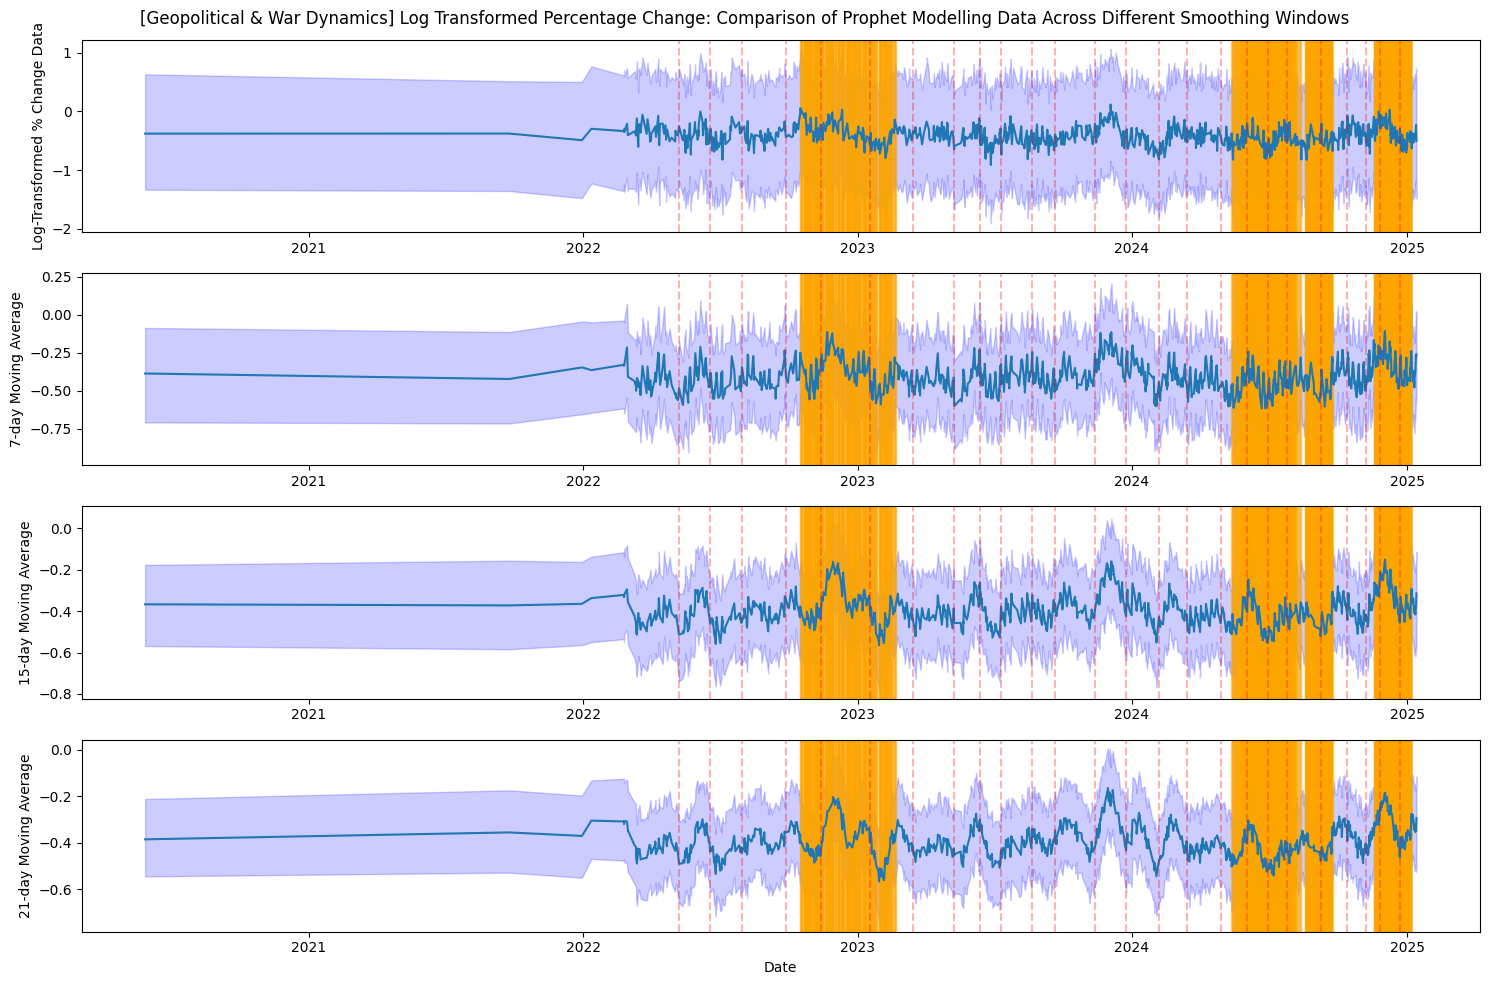

In [70]:
significat_changepoints = apply_prophet_model(df, "Geopolitical & War Dynamics")

In [71]:
significat_changepoints

date     magnitude
107  2022-06-18 21:32:55  0.0015383600
161  2022-07-31 07:10:00  0.0000000604
1285 2024-11-26 10:45:37  0.0000000325
54   2022-05-08 12:19:23  0.0000000303
375  2023-03-15 07:05:24  0.0000000063
1339 2024-12-22 09:08:38  0.0000000029
268  2022-11-12 22:31:29  0.0000000023
482  2023-06-12 18:03:13  0.0000000014
589  2023-08-21 08:17:04  0.0000000006
321  2023-01-17 10:35:49 -0.0000000012
214  2022-09-27 20:09:31 -0.0000000101
536  2023-07-10 21:27:08 -0.0000000122
1232 2024-11-06 17:49:01 -0.0000000313
1178 2024-10-12 16:37:58 -0.0000000370
428  2023-05-09 12:22:40 -0.0000000490
643  2023-09-20 20:44:15 -0.0000090139
1125 2024-09-08 22:37:01 -0.0000707995
750  2023-12-24 04:25:20 -0.0001482560
964  2024-06-02 08:35:20 -0.0005906080
696  2023-11-12 17:41:39 -0.0007219550
1071 2024-07-25 07:17:30 -0.0008279350
911  2024-04-27 19:00:05 -0.0039997900
857  2024-03-13 16:00:07 -0.0123489000
1018 2024-06-29 09:04:10 -0.0159275000
803  2024-02-05 19:21:52 -0.0200588000

#### Environmental and Climate Issues

17:10:31 - cmdstanpy - INFO - Chain [1] start processing
17:10:31 - cmdstanpy - INFO - Chain [1] done processing
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
17:10:32 - cmdstanpy - INFO - Chain [1] done processing
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
17:10:32 - cmdstanpy - INFO - Chain [1] done processing
17:10:32 - cmdstanpy - INFO - Chain [1] start processing
17:10:32 - cmdstanpy - INFO - Chain [1] done processing


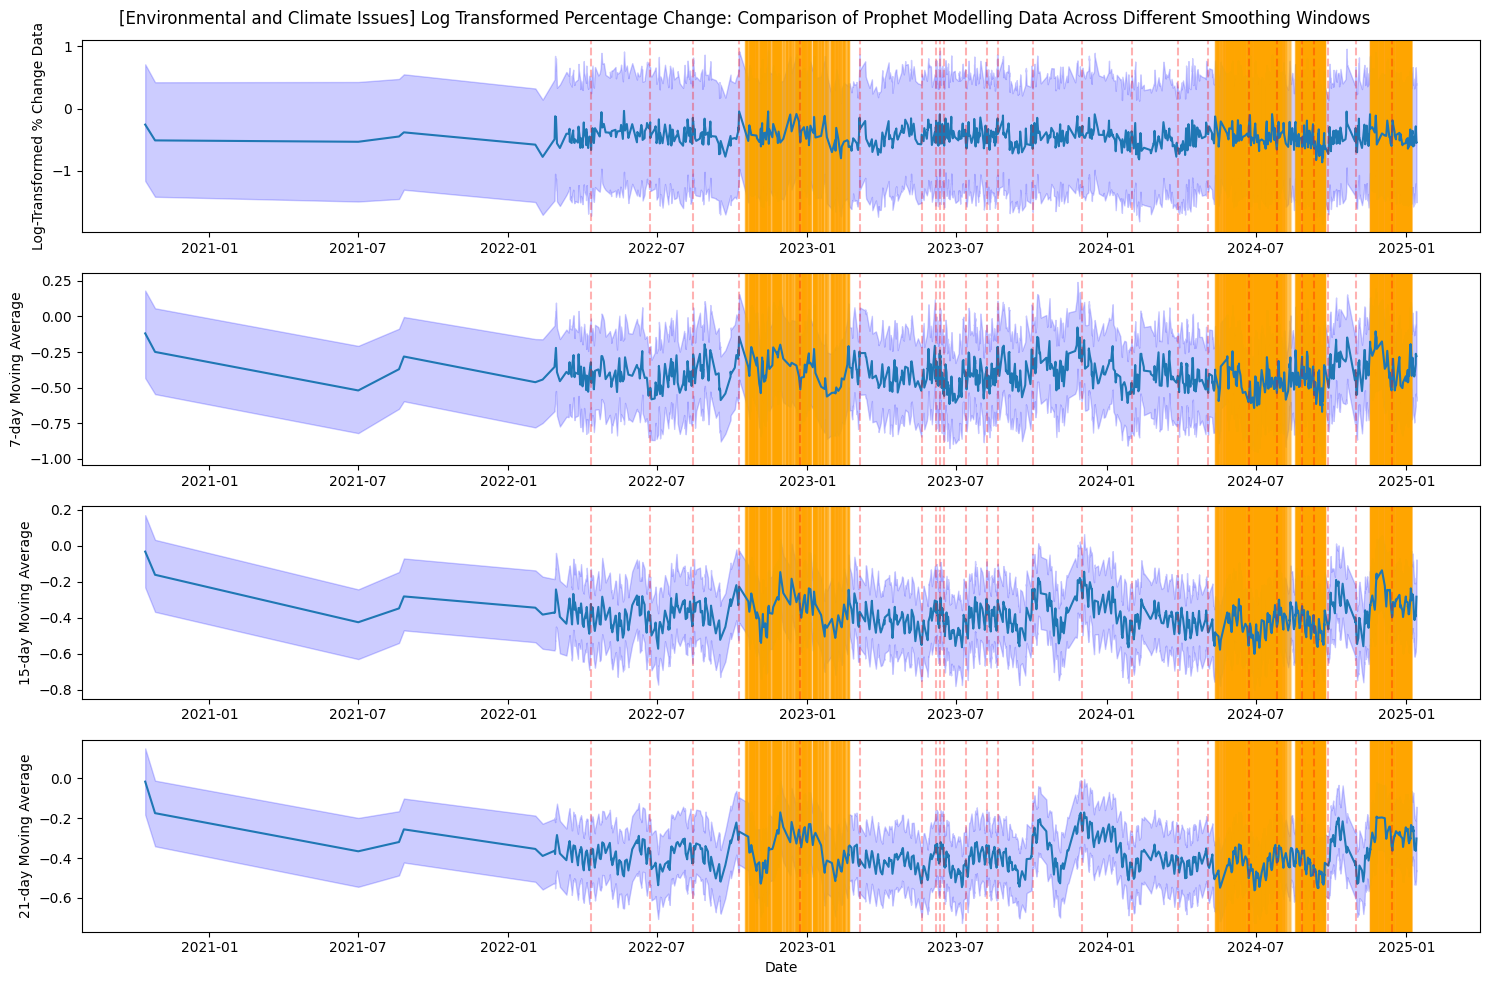

In [72]:
climate_issues_significat_changepoints = apply_prophet_model(df, "Environmental and Climate Issues")

In [74]:
climate_issues_significat_changepoints

date     magnitude
105  2022-06-23 01:48:41  0.1267840000
53   2022-04-11 20:15:56  0.1125540000
158  2022-08-14 02:17:12  0.1114750000
211  2022-10-09 08:17:53  0.0923444000
264  2022-12-23 05:54:09  0.0695508000
316  2023-03-05 18:10:00  0.0449796000
369  2023-05-20 07:54:40  0.0070301200
422  2023-06-07 09:50:39  0.0000119410
580  2023-07-13 06:01:51  0.0000009880
633  2023-08-08 10:50:09  0.0000008229
474  2023-06-11 06:03:32  0.0000005830
685  2023-08-21 06:51:45  0.0000004035
527  2023-06-16 22:18:58  0.0000002884
791  2023-12-01 13:44:16  0.0000000191
738  2023-10-03 15:20:12  0.0000000103
896  2024-03-28 09:20:52  0.0000000099
1213 2024-09-27 17:58:20  0.0000000096
1265 2024-10-31 13:38:01  0.0000000074
1002 2024-06-22 07:32:38  0.0000000021
1160 2024-09-10 16:16:32  0.0000000018
844  2024-01-31 11:18:18  0.0000000000
1318 2024-12-14 22:40:59 -0.0000000015
1107 2024-08-26 20:12:56 -0.0000000062
949  2024-05-03 13:27:31 -0.0000000114
1054 2024-07-26 20:54:00 -0.0000000544

#### War-Related Environmental and Resource Impact

17:11:03 - cmdstanpy - INFO - Chain [1] start processing
17:11:03 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing
17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:04 - cmdstanpy - INFO - Chain [1] done processing


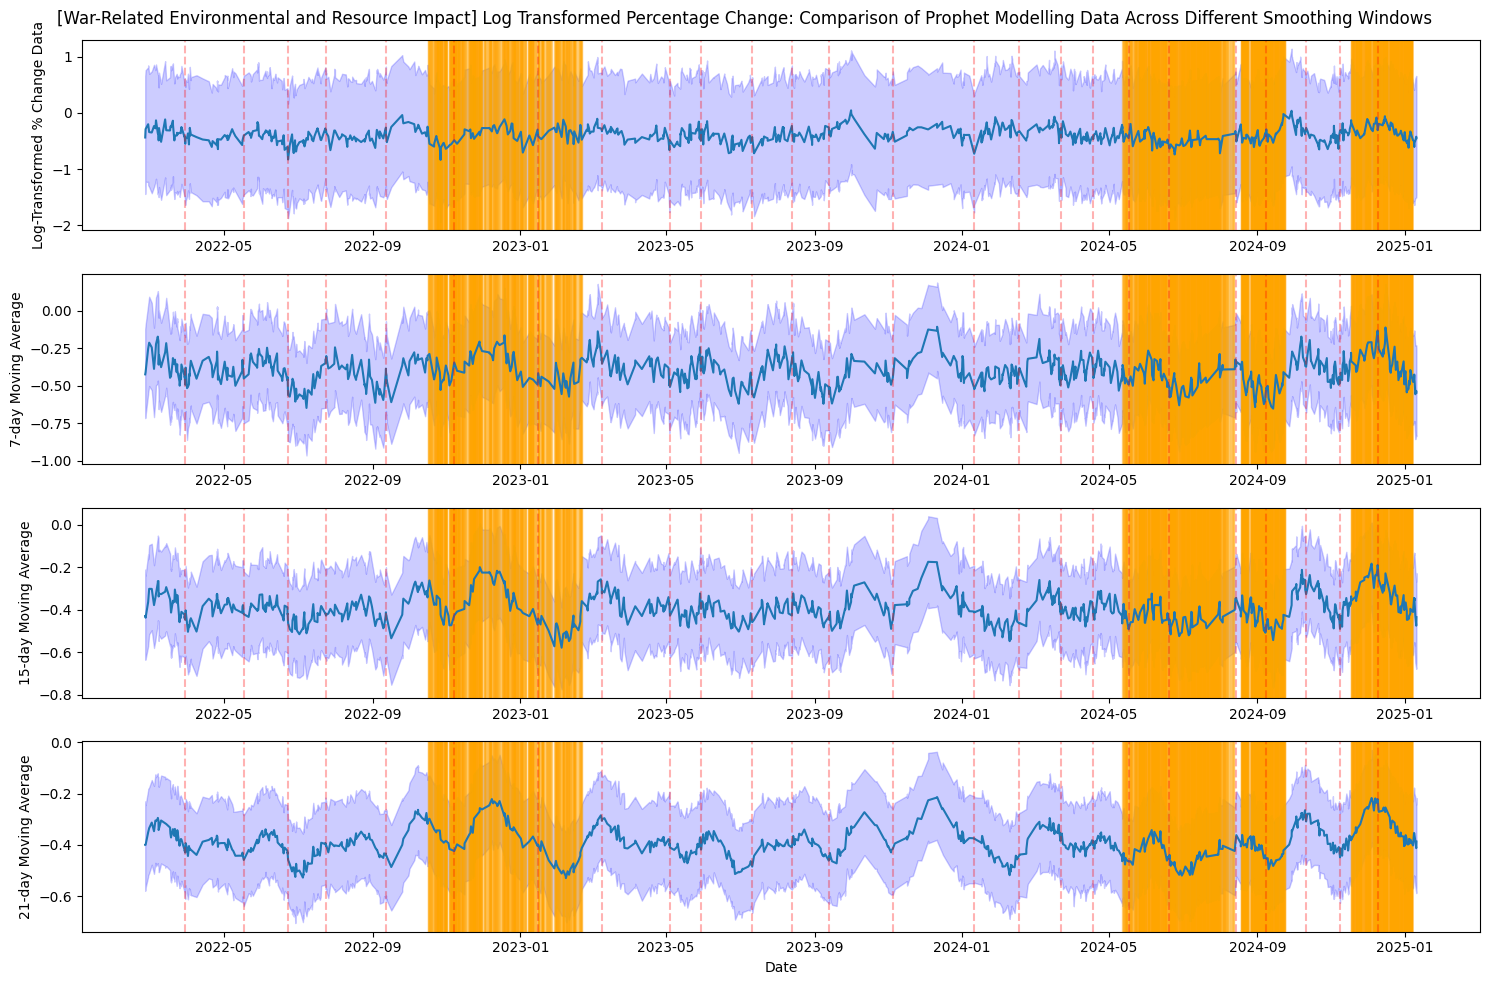

In [75]:
war_related_env_impact_significat_changepoints = apply_prophet_model(df, "War-Related Environmental and Resource Impact")

In [76]:
war_related_env_impact_significat_changepoints

date     magnitude
260  2022-11-07 05:26:56  0.0001153930
304  2023-01-15 14:21:05  0.0000041823
347  2023-03-09 06:48:45  0.0000029237
217  2022-09-11 17:58:18  0.0000001242
998  2024-10-11 04:48:33  0.0000000175
391  2023-05-04 06:39:44  0.0000000097
434  2023-05-30 04:56:23  0.0000000075
87   2022-05-17 07:36:21  0.0000000068
564  2023-09-13 05:04:04  0.0000000030
477  2023-07-11 11:16:00  0.0000000003
174  2022-07-24 12:17:19 -0.0000000005
43   2022-03-29 13:23:47 -0.0000000019
521  2023-08-13 14:24:23 -0.0000000076
130  2022-06-22 11:32:55 -0.0000000101
651  2024-01-10 22:13:43 -0.0000000177
1085 2024-12-09 07:04:55 -0.0000000258
1042 2024-11-08 05:15:18 -0.0000000277
608  2023-11-04 15:37:35 -0.0000000641
911  2024-08-14 10:34:23 -0.0000029321
955  2024-09-08 07:39:44 -0.0000115451
825  2024-05-17 12:54:03 -0.0016536400
694  2024-02-17 06:35:32 -0.0023658300
781  2024-04-18 08:13:48 -0.0035740600
738  2024-03-22 08:16:38 -0.0068373000
868  2024-06-20 05:34:43 -0.0129641000

#### Energy and Resources

17:11:28 - cmdstanpy - INFO - Chain [1] start processing
17:11:28 - cmdstanpy - INFO - Chain [1] done processing
17:11:29 - cmdstanpy - INFO - Chain [1] start processing
17:11:29 - cmdstanpy - INFO - Chain [1] done processing
17:11:29 - cmdstanpy - INFO - Chain [1] start processing
17:11:29 - cmdstanpy - INFO - Chain [1] done processing
17:11:29 - cmdstanpy - INFO - Chain [1] start processing
17:11:29 - cmdstanpy - INFO - Chain [1] done processing


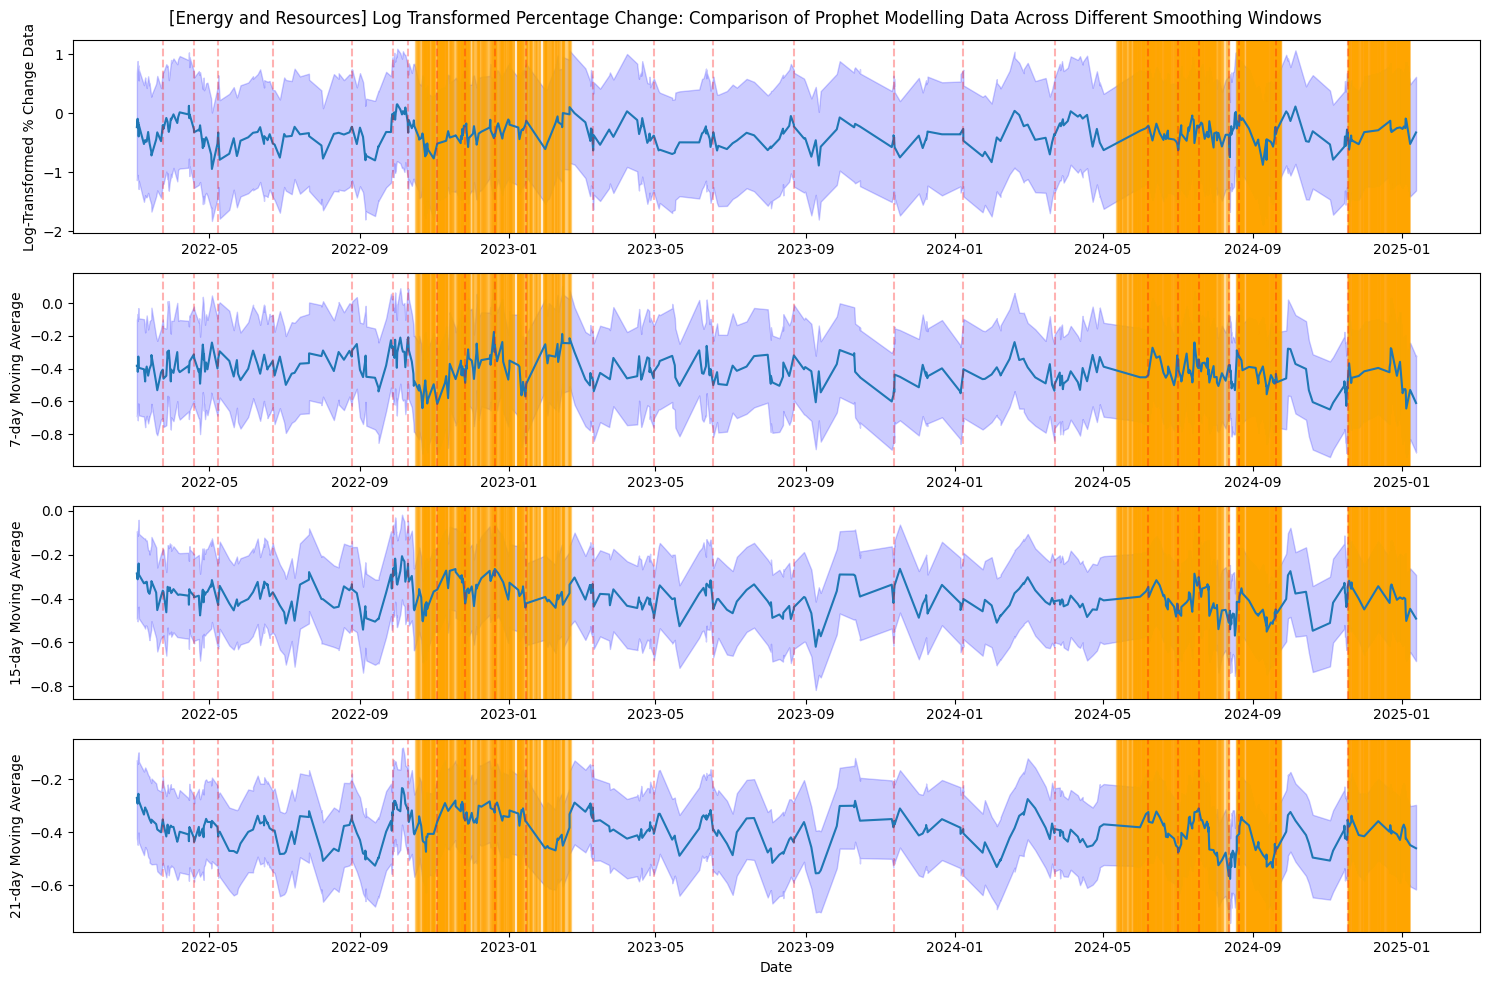

In [77]:
energy_resources_significat_changepoints = apply_prophet_model(df, "Energy and Resources")

In [78]:
energy_resources_significat_changepoints

date     magnitude
422 2024-07-18 13:10:00  0.0000000064
141 2022-10-10 07:31:22  0.0000000058
462 2024-08-20 21:52:45  0.0000000005
100 2022-08-25 13:41:04 -0.0000000004
80  2022-06-21 20:55:13 -0.0000000006
161 2022-11-03 11:04:17 -0.0000000011
201 2022-12-20 11:07:53 -0.0000000015
120 2022-09-27 21:42:20 -0.0000000016
221 2023-01-15 07:39:59 -0.0000000017
60  2022-05-08 06:45:44 -0.0000000021
442 2024-08-12 06:32:32 -0.0000000029
482 2024-09-19 12:18:37 -0.0000000034
241 2023-03-11 01:24:41 -0.0000000037
502 2024-11-17 09:36:01 -0.0000000038
20  2022-03-24 10:50:38 -0.0000000044
181 2022-11-26 07:54:52 -0.0000000047
40  2022-04-18 11:33:59 -0.0000000083
402 2024-07-01 18:10:00 -0.0001111140
382 2024-06-07 09:12:29 -0.0004366020
281 2023-06-17 03:50:18 -0.0005447350
261 2023-04-29 17:18:34 -0.0009995550
361 2024-03-22 15:00:01 -0.0040801500
301 2023-08-22 06:35:38 -0.0376105000
321 2023-11-12 08:00:07 -0.0849159000
341 2024-01-07 23:55:53 -0.0977050000

#### Miscellaneous

17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:48 - cmdstanpy - INFO - Chain [1] start processing
17:11:48 - cmdstanpy - INFO - Chain [1] done processing


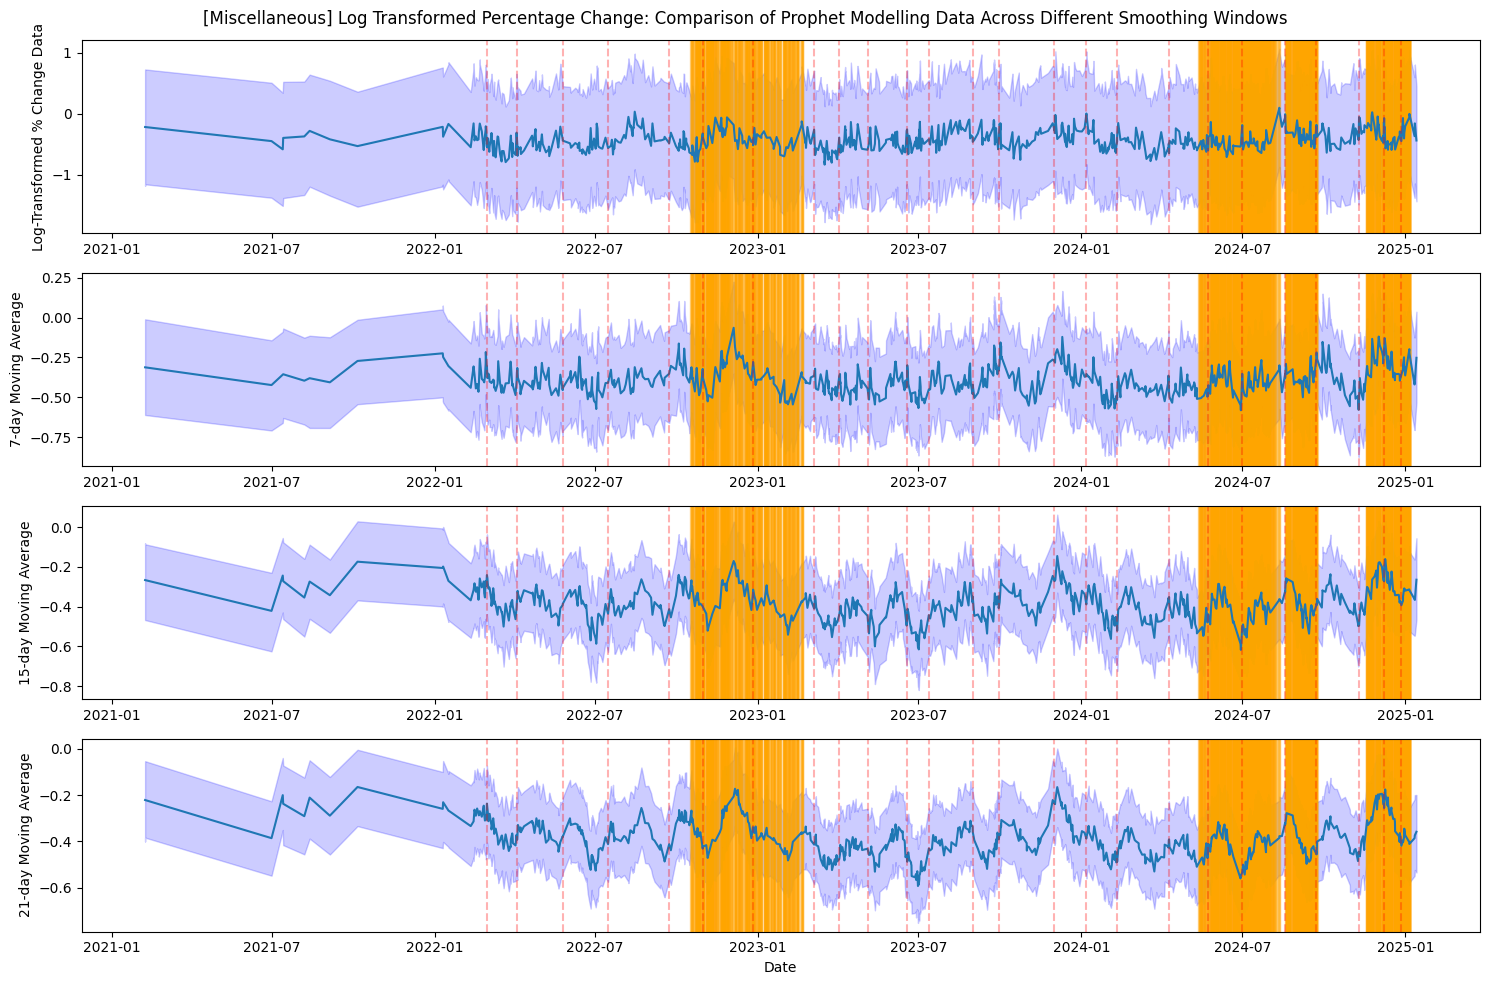

In [79]:
miscellaneous_significat_changepoints = apply_prophet_model(df, "Miscellaneous")

In [80]:
miscellaneous_significat_changepoints

date     magnitude
203 2022-10-30 14:26:14  0.1024050000
169 2022-09-22 13:53:38  0.0996361000
135 2022-07-15 13:28:46  0.0929871000
237 2022-12-26 05:30:00  0.0924558000
271 2023-03-05 07:10:00  0.0764553000
102 2022-05-25 08:25:06  0.0697835000
305 2023-04-02 15:00:04  0.0697071000
338 2023-05-04 13:40:56  0.0520331000
372 2023-06-18 06:29:59  0.0353922000
68  2022-04-03 05:33:51  0.0271557000
406 2023-07-12 19:35:35  0.0252467000
474 2023-09-29 16:51:52  0.0005768890
440 2023-08-31 06:02:46  0.0000024981
34  2022-02-28 16:30:04  0.0000001205
812 2024-12-07 19:06:13  0.0000000146
541 2024-01-06 17:23:54  0.0000000103
609 2024-04-09 03:15:58  0.0000000015
643 2024-05-23 10:53:16 -0.0000000010
711 2024-08-18 04:01:55 -0.0000000032
575 2024-02-10 11:56:36 -0.0000000060
846 2024-12-26 12:42:01 -0.0000000063
778 2024-11-09 04:01:30 -0.0000000129
677 2024-06-30 18:34:54 -0.0000000139
508 2023-12-01 16:54:44 -0.0000000192
744 2024-09-22 14:46:09 -0.0000000245

### Prepare 21MA for each topic on a separate plot

In [126]:
def fit_prophet_and_get_future_forecast(outage_df, data, column='y', outage_column='outage', n_changepoints=25, 
                                    changepoint_prior_scale=0.05, changepoint_range=0.95, yearly_seasonality=True, weekly_seasonality=True):
    # Prepare dataframe
    prophet_df = data[['ds', column, outage_column]].rename(columns={column: 'y'})
    
    # Fit model
    model = Prophet(n_changepoints=n_changepoints,
                    changepoint_prior_scale=changepoint_prior_scale,
                    changepoint_range=changepoint_range,
                    yearly_seasonality=yearly_seasonality,
                    weekly_seasonality=weekly_seasonality
                   )

    # Add electricity outages as additional regressors
    model.add_regressor('outage')

    model.fit(prophet_df)
    
    # Get forecast and extract changepoint information
    future = model.make_future_dataframe(periods=0)  # No forecasting needed
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=0)  # No forecast, just analyze historical data
    if 'outage' in outage_df.columns:
        future = future.merge(outage_df[['ds', 'outage']], on='ds', how='left')

    forecast = model.predict(future)
    
    return model, forecast, prophet_df


def visualize_forecasts(outage_df, topic_names, forecasts, models, dfs):
    plt.figure(figsize=(15, 10))
    
    # Create subplots for each time series
    ax1 = plt.subplot(5, 1, 1)
    ax2 = plt.subplot(5, 1, 2)
    ax3 = plt.subplot(5, 1, 3)
    ax4 = plt.subplot(5, 1, 4)  
    ax5 = plt.subplot(5, 1, 5, sharex=ax1) # Share x-axis with first plot

    axs = [ax1, ax2, ax3, ax4, ax5]

    # Plot each time series with vertical lines for changepoints
    for i, topic_name in enumerate(topic_names):
        # Plot the time series
        axs[i].plot(forecasts[i]['ds'], forecasts[i]['yhat'])
        axs[i].set_title(topic_name)
        # axs[i].set_ylabel("Log-transformed % change")
        axs[i].fill_between(forecasts[i]['ds'], forecasts[i]['yhat_lower'], forecasts[i]['yhat_upper'], 
                    color='blue', alpha=0.2, label='Uncertainty')
    
        cp_data = pd.DataFrame(models[i].changepoints)
        
        # Add vertical lines for top 5 changepoints
        for j, row in cp_data.iterrows():
            axs[i].axvline(x=row['ds'], color='r', linestyle='--', alpha=0.3)
            # ax.text(row['date'], ax.get_ylim()[1], f"{row['date'].date()}", 
                    # rotation=90, verticalalignment='top', fontsize=9)
    
        # Highlight outage periods if available
        if 'outage' in outage_df.columns:
            outage_periods = outage_df[outage_df['outage'] == 1]['ds']
            for date in outage_periods:
                axs[i].axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='orange')
            
            # Add outage period label
            axs[i].plot([], [], color='orange', alpha=0.2, linewidth=3, label='Outage Periods')
    
    ax4.set_xlabel('Date')
    # plt.title(f'21-days Moving Average of Log Transformed Percentage Change: Comparison Across Topic Groups')
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


def visualize_forecasts_enhanced(outage_df, topic_names, forecasts, models, dfs):
    # Create figure with more space for titles and labels
    fig = plt.figure(figsize=(15, 10))
    
    # Add main title with enough space
    fig.suptitle('21-day Moving Average of Reactions Score: Comparison Across Topic Groups', 
                 fontsize=14, y=0.98)
    
    # Create subplot grid with more space between plots
    gs = fig.add_gridspec(5, 1, hspace=0.2)
    
    # Create axes with shared x-axis
    axs = []
    for i in range(5):
        ax = fig.add_subplot(gs[i, 0])
        axs.append(ax)
        
        # Share x-axis with first plot
        if i > 0:
            ax.sharex(axs[0])
    
    # Plot each time series
    for i, topic_name in enumerate(topic_names):
        # Plot forecast line
        axs[i].plot(forecasts[i]['ds'], forecasts[i]['yhat'], color='blue', linewidth=1)
        
        # Add uncertainty bands
        axs[i].fill_between(forecasts[i]['ds'], forecasts[i]['yhat_lower'], forecasts[i]['yhat_upper'], 
                    color='blue', alpha=0.2, label='Uncertainty')
        
        # Set subplot title and y-axis label
        axs[i].set_title(f"Topic: {topic_name}", fontsize=12)
        axs[i].set_ylabel("Log-transformed\n% change", fontsize=10)
        
        # Add grid for better readability
        axs[i].grid(True, alpha=0.3, linestyle='--')
        
        # Add vertical lines for changepoints
        cp_data = pd.DataFrame(models[i].changepoints)
        for j, row in cp_data.iterrows():
            axs[i].axvline(x=row['ds'], color='r', linestyle='--', alpha=0.3)
        
        # Add collective label for changepoints if it's the first subplot
        if i == 0:
            axs[i].plot([], [], color='r', linestyle='--', alpha=0.7, label='Changepoints')
        
        # Highlight outage periods if available
        if 'outage' in outage_df.columns:
            outage_periods = outage_df[outage_df['outage'] == 1]['ds']
            for date in outage_periods:
                axs[i].axvspan(date, date + pd.Timedelta(days=1), alpha=0.2, color='orange')
            
            # Add outage period label if it's the first subplot
            if i == 0:
                axs[i].plot([], [], color='orange', alpha=0.5, linewidth=3, label='Outage Periods')
    
    # Add legend to the first subplot
    axs[0].legend(loc='upper right', framealpha=0.8)
    
    # Only show x-label on bottom subplot
    for i in range(4):
        axs[i].tick_params(labelbottom=False)
    
    # Format x-axis for bottom subplot
    axs[4].set_xlabel('Date', fontsize=12)
    axs[4].tick_params(axis='x', rotation=45)
    
    # Format dates nicely
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    axs[4].xaxis.set_major_locator(locator)
    axs[4].xaxis.set_major_formatter(formatter)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)  # Make room for main title
    
    return fig  # Return the figure so it can be saved if needed

In [121]:
def prepare_topic_artifacts(df, topic_names, column="ma21"): 
    # Prepare data for Prophet
    # Prophet requires a specific format with 'ds' (date) and 'y' (target variable)
    outage_df = df[['ds', 'outage']]

    
    models = []
    forecasts = []
    transformed_dfs = []
    
    for topic_name in topic_names:
        topic_df = df[df["Primary Topic"] == topic_name]
    
        model, forecast, transformed_df = fit_prophet_and_get_future_forecast(
            outage_df, topic_df[["ds", column, "outage"]], column=column
        )
        
        models.append(model)
        forecasts.append(forecast)
        transformed_dfs.append(transformed_df)

    return outage_df, forecasts, models, transformed_dfs


def prepare_changepoints_df(model):
    # Extract changepoints with their magnitudes
    cp_dates = model.changepoints
    cp_effects = model.params['delta'].flatten()
    
    # Create dataframe of changepoints
    changepoints = pd.DataFrame({
        'date': cp_dates,
        'magnitude': cp_effects
    }).sort_values('magnitude', ascending=False)
    
    return changepoints
        


def apply_prophet_model(df, column):
    topic_names = list(df['Primary Topic'].unique())
    outage_df, forecasts, models, dfs = prepare_topic_artifacts(df, topic_names, column=column)
    # visualize_forecasts(outage_df, topic_names, forecasts, models, dfs)
    visualize_forecasts_enhanced(outage_df, topic_names, forecasts, models, dfs)

    # selecting the last model with 21-day MA
    # ma21_model = models[-1]
    # ma21_changepoints_df = prepare_changepoints_df(ma21_model)

    # return ma21_changepoints_df

17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/mc/36xkpyzx5hn6t7wmy23pdz5c0000gn/T/ipykernel_2235/2260373401.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


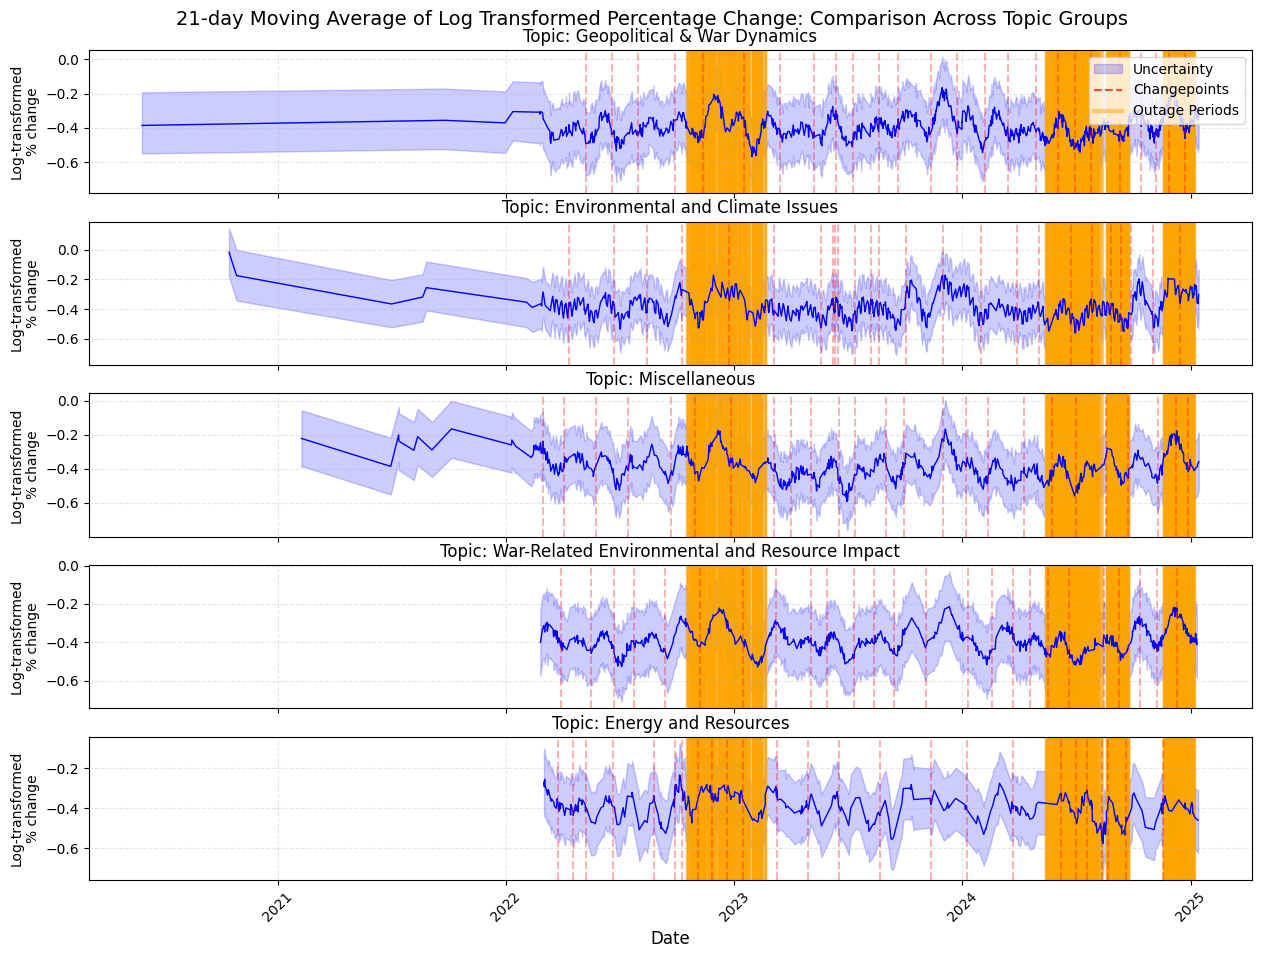

In [118]:
apply_prophet_model(df)

18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:31 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing
18:07:32 - cmdstanpy - INFO - Chain [1] start processing
18:07:32 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/mc/36xkpyzx5hn6t7wmy23pdz5c0000gn/T/ipykernel_2235/2236794163.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


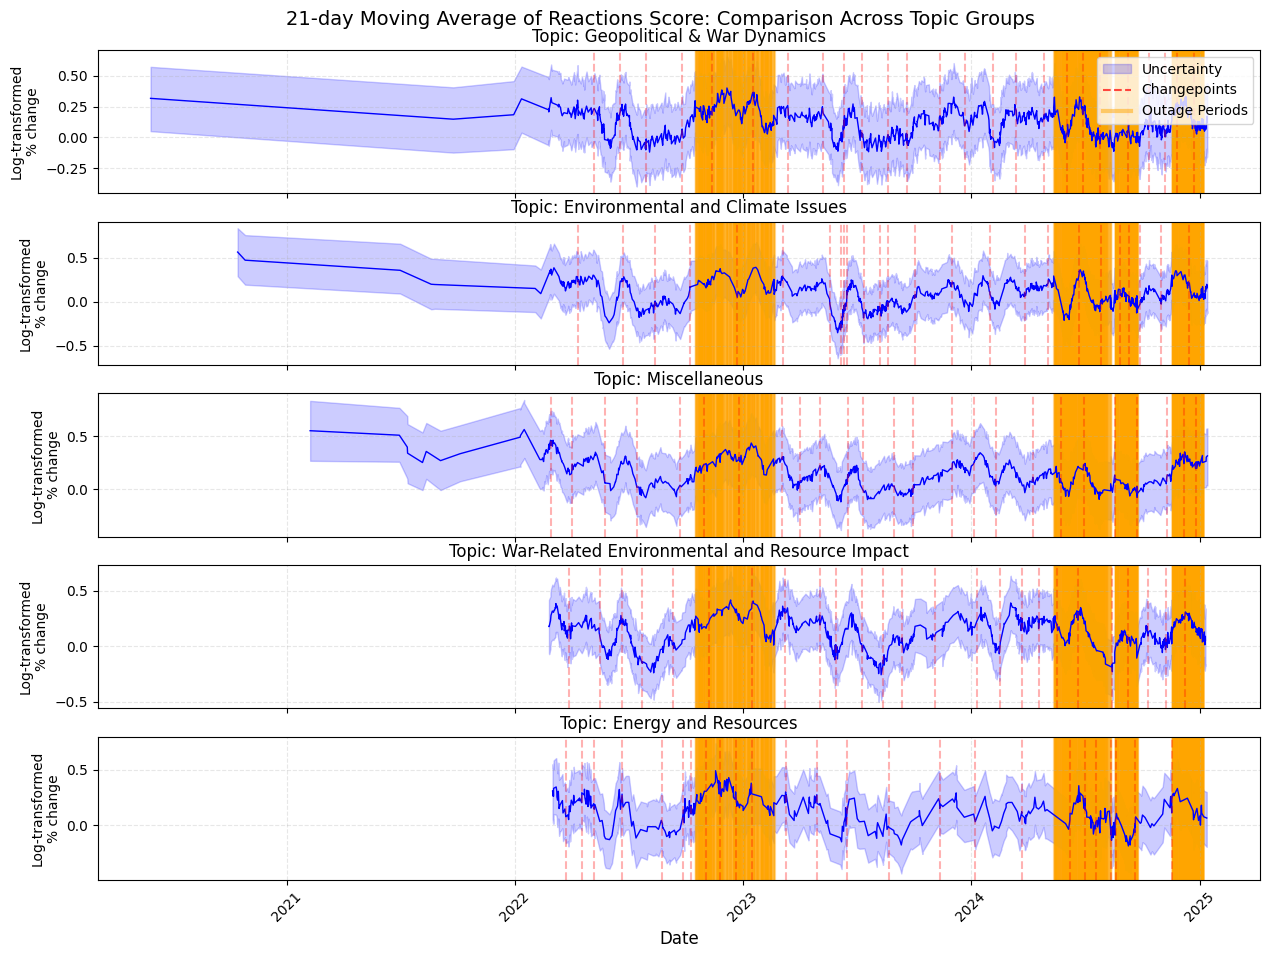

In [127]:
apply_prophet_model(df, column='reactions_score_ma21')